# Hospice Utilization by Minorites
## Investigator: J. Patrick Bernard
## MSDS692 DataSciencePracticum 2

### Purpose:  
The purpose of my project is to investigate utilization of Hospice care by minority racial groups. There is a history of racial groups having lower levels of access to medical care. Is also true for hospice care? My goal is not to explain why or how this is occurring, that is the job of social and healthcare professionals. My goal is to collect and evaluate the data so that these professionals can direct their effort in the best way possible.  the region of concern will be Louisiana and Mississippi.  

### Data Source:  
2018 Medicare hospice claims.  

### Data Classifier Develoment

In this notebook I develop a model for each state and classify the benificeary on race. 




**References**  
https://dataaspirant.com/random-forest-algorithm-machine-learing/  
https://machinelearningmastery.com/implement-random-forest-scratch-python/  
https://machinelearningmastery.com/random-forest-ensemble-in-python/  
https://www.datacamp.com/community/tutorials/random-forests-classifier-python  
https://www.datacamp.com/community/tutorials/random-forests-classifier-python#building  


In [1]:
# packages
import pandas as pd
import numpy as np
from numpy.random import randint
import re
import csv
import os
import pickle
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#format the work space
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
# These are the dictionary descriptions for the categorical data
states = {1:'Alabama',2:'Alaska',3:'Arizona',4:'Arkansas',5:'California',6:'Colorado',7:'Connecticut',8:'Delaware',
          9:'DistOCol',10:'Florida',11:'Georgia',12:'Hawaii',13:'Idaho',14:'Illinois',15:'Indiana',16:'Iowa',17:'Kansas',
          18:'Kentucky',19:'Louisiana',20:'Maine',21:'Maryland',22:'Massachusetts',23:'Michigan',24:'Minnisota',
          25:'Mississippi',26:'Missouri',27:'Montana',28:'Nebraska',29:'Nevada',30:'NewHampshire',31:'NewJersey',
          32:'NewMexico',33:'NewYork',34:'NorthCarolina',35:'NorthDakota',36:'Ohio',37:'Oklahoma',38:'Oregon',39:'Pennsylvainia',
          40:'PuertoRico',41:'RhodeIsland',42:'SouthCarolina',43:'SouthDakota',44:'Tennessee',45:'Texas',46:'Utah',47:'Vermont',
          48:'VirginIsland',49:'Virginia',50:'Washington',51:'WestVirgina',52:'Wisconson',53:'Wyoming',54:'Africa',55:'Canada_Islands',
          56:'CentAmerWstInd',57:'Europe',58:'Mexico',59:'Oceania',60:'Philippines',61:'SouthAmerica',62:'UsPosessions',
          63:'AmericanSamoa',64:'Guam',65:'SaipanNorthMarianas',97:'NorthernMarianas',98:'Guam',99:'Unknown'}
Race = {0:'Unknown', 1:'White',2:'Black',3:'Other',4:'Asian',5:'Hispanic',6:'North_American_Native'}
Race_WBAllOther  = {1:'White',2:'Black',3:'All Other'}
AgeGroups = {0:'Unknown',1:'<64',2:'64-69',3:'70-74',4:'75-79',5:'80-84',6:'>84'}
PTDCSTUS = {0:'Missing',1:'Still Patient',2:'DC Alive',3:'DC Deceased'}

In [4]:
# D_SSA is a look up table for the county id
SSA = pd.read_csv('e:/PatrickBernard/d_ssa.csv',names = ['county_id', 'county'])
#D_SSA.set_index('county_id',inplace = True)  
SSA.sample(3)

,county_id,county
1235,23030,Alpena MI
373,10520,Polk FL
1773,30080,Strafford NH


In [5]:
# this cel retrieve data for one state so tht a mode lcan be developed before funning the model on all of the states.


subject_states = [19]#,25]

for s in subject_states:
    with open(f'e:/PatrickBernard/{states[s]}MBSF2018.pkl', 'rb') as f:
        regional_data = pickle.load(f)


In [6]:
regional_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893266 entries, 1 to 344680
Data columns (total 61 columns):
Bene_ID                  893266 non-null int64
D_State                  893266 non-null int64
D_SSA                    893266 non-null int64
D_SSA2                   893266 non-null int64
D_Bene                   893266 non-null int64
D_DIED                   893266 non-null int64
D_DOD_Date               35312 non-null datetime64[ns]
D_Sex                    893266 non-null int64
D_Race                   893266 non-null int64
D_Race_WBAllOther        893266 non-null int64
D_Age                    893266 non-null int64
D_AgeGroups              893266 non-null int64
D_TM                     893266 non-null int64
D_TM_Died                893266 non-null int64
D_MA_Plan                893266 non-null int64
D_MA_Plan_Died           893266 non-null int64
D_MS_CD                  893266 non-null int64
D_OREC                   893266 non-null int64
D_CREC                   893266 non

In [7]:
regional_data.columns

Index(['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2', 'D_Bene', 'D_DIED',
       'D_DOD_Date', 'D_Sex', 'D_Race', 'D_Race_WBAllOther', 'D_Age',
       'D_AgeGroups', 'D_TM', 'D_TM_Died', 'D_MA_Plan', 'D_MA_Plan_Died',
       'D_MS_CD', 'D_OREC', 'D_CREC', 'D_ESRD', 'D_State_BuyIn_Dual',
       'D_HOS_PT', 'D_HOS_PROVIDER_ID', 'D_HOS_ProviderNameID',
       'D_HOS_PTDCSTUS', 'D_HOS_Died', 'D_HOS_CCS', 'D_HOS_pdx',
       'D_HOS_UTIL_DAY', 'D_HOS_PMT_AMT', 'D_INPT_PT', 'D_INPT_PROVIDER_ID',
       'D_INPT_ProviderNameID', 'D_INPT_DC_Status', 'D_INPT_Died',
       'D_INPT_CCS', 'D_INPT_pdx', 'D_INPT_UTIL_DAY', 'D_INPT_PMT_AMT',
       'D_SNF_PT', 'D_SNF_PROVIDER_ID', 'D_SNF_ProviderNameID',
       'D_SNF_DC_Status', 'D_SNF_Died', 'D_SNF_CCS', 'D_SNF_pdx',
       'D_SNF_UTIL_DAY', 'D_SNF_PMT_AMT', 'D_HHA_PT', 'D_HHA_PROVIDER_ID',
       'D_HHA_ProviderNameID', 'D_HHA_PTDCSTUS', 'D_HHA_DIED', 'D_HHA_CCS',
       'D_HHA_pdx', 'D_HHA_Episodes', 'D_HHA_Visits', 'D_HHA_Days',
       'D_HHA_PMT_AMT', 

In [8]:
regional_data.sample(4)

,Bene_ID,D_State,D_SSA,D_SSA2,D_Bene,D_DIED,D_DOD_Date,D_Sex,D_Race,D_Race_WBAllOther,...,D_HHA_PTDCSTUS,D_HHA_DIED,D_HHA_CCS,D_HHA_pdx,D_HHA_Episodes,D_HHA_Visits,D_HHA_Days,D_HHA_PMT_AMT,Total_Pay,N_Providers
342778,108693407,19,19160,1,1,0,NaT,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
117162,445017045,19,19090,1,1,0,NaT,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
274265,465396363,19,19560,1,1,0,NaT,2,1,1,...,2.0,0.0,113,3,1,21.0,118.0,3458.29,NaN,2
396627,475335760,19,19020,1,1,0,NaT,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [9]:
features = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Race','D_Age','D_TM', 'D_TM_Died',
            'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY',
            'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
            'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
            'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days','RANDOM_NUM']

labels = ['D_HOS_PTDCSTUS']

### Create Classifier

In [10]:
# Import packages for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [11]:
# impute missing data
regional_data.fillna(-999, inplace = True)
regional_data['RANDOM_NUM'] = randint(0, 10) # create a random number field
regional_data.sample(5)

,Bene_ID,D_State,D_SSA,D_SSA2,D_Bene,D_DIED,D_DOD_Date,D_Sex,D_Race,D_Race_WBAllOther,...,D_HHA_DIED,D_HHA_CCS,D_HHA_pdx,D_HHA_Episodes,D_HHA_Visits,D_HHA_Days,D_HHA_PMT_AMT,Total_Pay,N_Providers,RANDOM_NUM
27282,485283644,19,19270,1,1,0,-999,2,2,2,...,-999.0,-999,-999,-999,-999.0,-999.0,-999.0,-999,0,8
304069,476235465,19,19020,1,1,0,-999,2,1,1,...,-999.0,-999,-999,-999,-999.0,-999.0,-999.0,-999,0,8
140419,463333270,19,19170,1,1,0,-999,1,2,2,...,-999.0,-999,-999,-999,-999.0,-999.0,-999.0,-999,0,8
388309,468383185,19,19100,1,1,0,-999,2,1,1,...,-999.0,-999,-999,-999,-999.0,-999.0,-999.0,-999,0,8
241493,445602393,19,19510,1,1,0,-999,2,1,1,...,-999.0,-999,-999,-999,-999.0,-999.0,-999.0,-999,0,8


In [12]:
# build the training and test data sets
X_data = regional_data[features]
y_data = regional_data['D_HOS_PTDCSTUS']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3) # 70% training 30% test

In [13]:
model = RandomForestClassifier(n_estimators=100, max_depth = 6, min_samples_leaf = 3)

# fit the model to predict on Hospice discharge status
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

In [15]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_data, y_data, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.998 (0.000)


In [16]:
print(f'classes: {model.classes_}\nnum_features: {model.n_features_}\noutputs: {model.n_outputs_} ')

classes: [-999.    1.    2.    3.]
num_features: 32
outputs: 1 


In [17]:
regional_data['hos_pred_dc'] = model.predict(regional_data[features])

In [18]:
regional_data[['D_HOS_PTDCSTUS','hos_pred_dc']][regional_data.D_HOS_PTDCSTUS!= -999].sample(10)

,D_HOS_PTDCSTUS,hos_pred_dc
271371,1.0,1.0
323391,3.0,3.0
244635,3.0,3.0
331426,3.0,3.0
343509,3.0,3.0
160561,3.0,3.0
98539,3.0,3.0
147236,3.0,3.0
329996,1.0,1.0
180412,3.0,3.0


In [19]:
 regional_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Bene_ID,893266.0,3.884603e+08,1.473155e+08,1.000000e+08,441462484.5,462194501.0,479630792.5,5.000000e+08
D_State,893266.0,1.900000e+01,0.000000e+00,1.900000e+01,19.0,19.0,19.0,1.900000e+01
D_SSA,893266.0,1.929583e+04,1.669710e+02,1.900000e+04,19160.0,19270.0,19440.0,1.999900e+04
D_SSA2,893266.0,1.000101e+00,1.419499e-02,1.000000e+00,1.0,1.0,1.0,3.000000e+00
D_Bene,893266.0,1.000000e+00,0.000000e+00,1.000000e+00,1.0,1.0,1.0,1.000000e+00
D_DIED,893266.0,3.953134e-02,1.948555e-01,0.000000e+00,0.0,0.0,0.0,1.000000e+00
D_Sex,893266.0,1.539853e+00,4.984095e-01,1.000000e+00,1.0,2.0,2.0,2.000000e+00
D_Race,893266.0,1.329620e+00,6.145359e-01,0.000000e+00,1.0,1.0,2.0,6.000000e+00
D_Race_WBAllOther,893266.0,1.348744e+00,5.389291e-01,1.000000e+00,1.0,1.0,2.0,3.000000e+00
D_Age,893266.0,6.910790e+01,1.197031e+01,0.000000e+00,65.0,69.0,76.0,9.800000e+01


Text(0.5, 1.0, 'RF Feature Importance (Louisiana)')

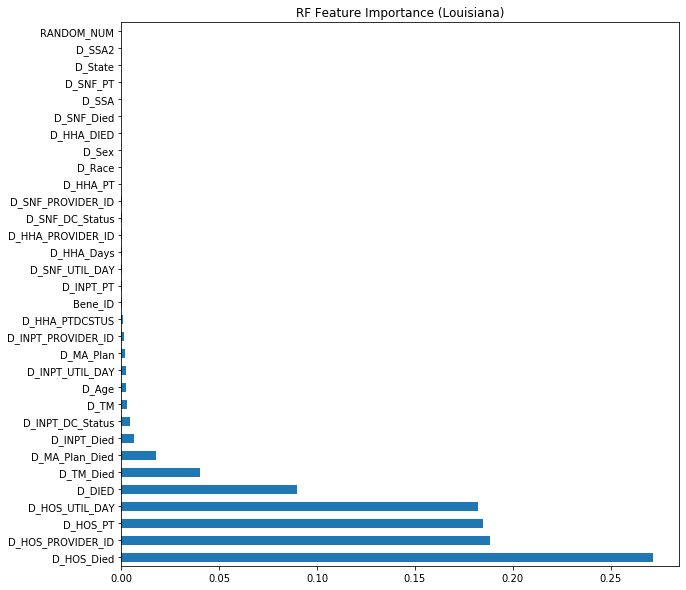

In [20]:
features_imp = pd.Series(model.feature_importances_, regional_data[features].columns)
features_imp.nlargest(34).plot(kind='barh')
plt.title(f'RF Feature Importance ({states[s]})')
#    plt.savefig(f'{figPath}{states[s]}_RF_FeatureImportance.png',bbox_inches = 'tight')


Text(0.5, 1.0, 'Hospice Discharge Status Confussion Matrics (Louisiana)')

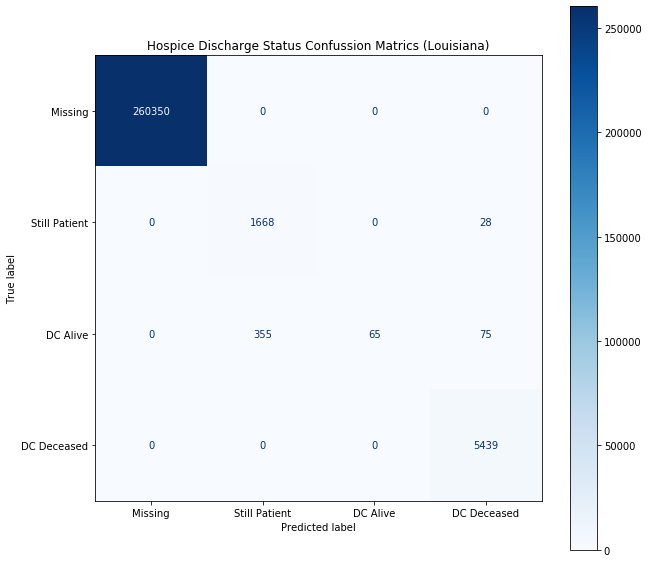

In [24]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=PTDCSTUS.values(),
                                 cmap=plt.cm.Blues,
                                 normalize=None)
plt.title(f'Hospice Discharge Status Confussion Matrics ({states[s]})')

In [31]:
#PTDCSTUS = {0:'Missing',1:'Still Patient',2:'DC Alive',3:'DC Deceased'}

regional_data[(regional_data.D_HOS_PTDCSTUS == 1) & (regional_data.hos_pred_dc == 3)].describe().T

,count,mean,std,min,25%,50%,75%,max
Bene_ID,99.0,2.744527e+08,1.706846e+08,100701657.0,132267802.0,1.363422e+08,4.733368e+08,4.982515e+08
D_State,99.0,1.900000e+01,0.000000e+00,19.0,19.0,1.900000e+01,1.900000e+01,1.900000e+01
D_SSA,99.0,1.930576e+04,1.650794e+02,19010.0,19210.0,1.935000e+04,1.941500e+04,1.959000e+04
D_SSA2,99.0,1.000000e+00,0.000000e+00,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
D_Bene,99.0,1.000000e+00,0.000000e+00,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
D_DIED,99.0,1.000000e+00,0.000000e+00,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
D_Sex,99.0,1.555556e+00,4.994328e-01,1.0,1.0,2.000000e+00,2.000000e+00,2.000000e+00
D_Race,99.0,1.414141e+00,7.955245e-01,0.0,1.0,1.000000e+00,2.000000e+00,6.000000e+00
D_Race_WBAllOther,99.0,1.424242e+00,5.905879e-01,1.0,1.0,1.000000e+00,2.000000e+00,3.000000e+00
D_Age,99.0,7.905051e+01,1.084715e+01,54.0,70.0,8.100000e+01,8.600000e+01,9.800000e+01


In [29]:
pd.set_option('display.max_columns', 63)

regional_data[(regional_data.D_HOS_PTDCSTUS == 1) & (regional_data.hos_pred_dc == 3)].sample(10)

,Bene_ID,D_State,D_SSA,D_SSA2,D_Bene,D_DIED,D_DOD_Date,D_Sex,D_Race,D_Race_WBAllOther,D_Age,D_AgeGroups,D_TM,D_TM_Died,D_MA_Plan,D_MA_Plan_Died,D_MS_CD,D_OREC,D_CREC,D_ESRD,D_State_BuyIn_Dual,D_HOS_PT,D_HOS_PROVIDER_ID,D_HOS_ProviderNameID,D_HOS_PTDCSTUS,D_HOS_Died,D_HOS_CCS,D_HOS_pdx,D_HOS_UTIL_DAY,D_HOS_PMT_AMT,D_INPT_PT,D_INPT_PROVIDER_ID,D_INPT_ProviderNameID,D_INPT_DC_Status,D_INPT_Died,D_INPT_CCS,D_INPT_pdx,D_INPT_UTIL_DAY,D_INPT_PMT_AMT,D_SNF_PT,D_SNF_PROVIDER_ID,D_SNF_ProviderNameID,D_SNF_DC_Status,D_SNF_Died,D_SNF_CCS,D_SNF_pdx,D_SNF_UTIL_DAY,D_SNF_PMT_AMT,D_HHA_PT,D_HHA_PROVIDER_ID,D_HHA_ProviderNameID,D_HHA_PTDCSTUS,D_HHA_DIED,D_HHA_CCS,D_HHA_pdx,D_HHA_Episodes,D_HHA_Visits,D_HHA_Days,D_HHA_PMT_AMT,Total_Pay,N_Providers,RANDOM_NUM,hos_pred_dc
333930,473772486,19,19250,1,1,1,2018-09-19 00:00:00,2,1,1,72,3,1,1,0,0,10,0,0,0,1,1,191646.0,MY HOSPICE 191646,1.0,0.0,19,2,46.0,6699.40,1,190146.0,EAST JEFFERSON GENERAL HOSPITAL 190146,2,0.0,2,10,25.0,48856.99,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,1,197758.0,GUARDIAN HOME HEALTH CARE OF LA. INC. 197758,1.0,0.0,127,17,1,24.0,119.0,3701.06,-999,3,8,3.0
101826,132379198,19,19350,1,1,1,2018-09-30 00:00:00,2,2,2,96,6,0,0,1,1,10,0,0,0,1,1,191589.0,CONCERNED CARE HOSPICE 191589,1.0,0.0,653,14,0.0,0.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,0,-999.0,-999,-999.0,-999.0,-999,-999,-999,-999.0,-999.0,-999.00,-999,1,8,3.0
357344,467397503,19,19510,1,1,1,2018-09-17 00:00:00,1,1,1,69,2,1,1,0,0,10,0,0,0,0,1,191516.0,ST TAMMANY HOSPITAL HOSPICE 191516,1.0,0.0,131,17,60.0,2621.04,1,190045.0,ST TAMMANY PARISH HOSPITAL 190045,2,0.0,102,25,0.0,0.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,0,-999.0,-999,-999.0,-999.0,-999,-999,-999,-999.0,-999.0,-999.00,-999,2,8,3.0
169994,450771152,19,19350,1,1,1,2018-08-18 00:00:00,1,2,2,66,2,0,0,1,1,10,0,0,0,1,1,191575.0,GUARDIAN ANGEL HOSPICE 191575,1.0,0.0,29,2,76.0,12014.94,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,0,-999.0,-999,-999.0,-999.0,-999,-999,-999,-999.0,-999.0,-999.00,-999,1,8,3.0
255726,487700631,19,19440,1,1,1,2018-10-09 00:00:00,2,5,3,76,4,0,0,1,1,10,0,0,0,1,1,191583.0,COMMUNITY HOSPICE LLC 191583,1.0,0.0,109,3,9.0,1490.14,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,0,-999.0,-999,-999.0,-999.0,-999,-999,-999,-999.0,-999.0,-999.00,-999,1,8,3.0
200818,136342177,19,19500,1,1,1,2018-09-30 00:00:00,2,2,2,83,5,1,1,0,0,10,0,0,0,1,1,191611.0,HEART OF HOSPICE 191611,1.0,0.0,19,2,67.0,10796.10,1,191310.0,FRANKLIN FOUNDATION HOSPITAL 191310,2,0.0,242,11,4.0,9125.76,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,1,197714.0,BAYOU HOME CARE 197714,2.0,0.0,98,3,2,46.0,119.0,3994.88,-999,3,8,3.0
177738,132901355,19,19270,1,1,1,2018-05-06 00:00:00,2,2,2,63,1,1,1,0,0,20,1,1,0,1,1,191665.0,HEALTH CARE OPTIONS HOSPICE OF LAFAYETTE INC ...,1.0,0.0,653,14,8.0,1303.69,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,0,-999.0,-999,-999.0,-999.0,-999,-999,-999,-999.0,-999.0,-999.00,-999,1,8,3.0
92917,132327762,19,19080,1,1,1,2018-09-06 00:00:00,2,1,1,92,6,1,1,0,0,10,0,0,0,0,1,191596.0,AIME HOSPICE CARE 191596,1.0,0.0,653,14,200.0,36774.39,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,0,-999.0,-999,-999.0,-999.0,-999,-999,-999,-999.0,-999.0,-999.00,-999,1,8,3.0
248145,130347106,19,19250,1,1,1,2018-11-22 00:00:00,1,1,1,90,6,0,0,1,1,10,0,0,0,0,1,191555.0,CANON HEALTHCARE HOSPICE 191555,1.0,0.0,158,7,304.0,39927.54,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.00,0,-999.0,-999,-999,-999.0,-999,-999,-999.0,-999.0,0,-999.0,-999,-999.0,-999.0,-999,-999,-999,-999.0,-999.0,-999.00,-999,1,8,3.0
203712,180090318,19,19220,1,1,1,2018-02-04 00:00:00,2,2,2,85,6,1,1,0,0,10,0,0,0,1,1,191611.0,HEART OF HOSPICE 191611,1.0,0.0,109,3,0.0,0.00,1,190054.0,IBERIA MEDICAL CENTER 190054,2,

### Build a Random Forest model to classify on Hospice Disharge Status

In [57]:
features = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Race','D_Age','D_TM', 'D_TM_Died',
            'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY',
            'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
            'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
            'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days','RANDOM_NUM']

# load the training data set
with open(f'e:/PatrickBernard/training_set.pk2', 'rb') as f:
        training_data = pickle.load(f)
# Create a random number of confounding
training_data['RANDOM_NUM'] = randint(0, 10)
# impute missing data
training_data.fillna(-999, inplace = True)
# build the training and test data sets
# X_data = training_data[feat_r]
# y_data = training_data['D_HOS_PTDCSTUS']

X_train, X_test, y_train, y_test = train_test_split(training_data[features],  training_data['D_HOS_PTDCSTUS'], test_size=0.25) # 75% training 25% test

model_discharge = RandomForestClassifier(n_estimators=100, max_depth = 6, min_samples_leaf = 3)

# fit the model to predict on Hospice discharge status
model_discharge.fit(X_train,y_train)

y_pred=model_discharge.predict(X_test)
pickle.dump(model_discharge,open('e:/PatrickBernard/hosDischarge/rf_model_discharge.mdl','wb'))

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_discharge, training_data[features],  training_data['D_HOS_PTDCSTUS'], scoring='accuracy',
                           cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.998 (0.000)


AlabamaMBSF2018.pkl
AlaskaMBSF2018.pkl
ArizonaMBSF2018.pkl
ArkansasMBSF2018.pkl
CaliforniaMBSF2018.pkl
ColoradoMBSF2018.pkl
ConnecticutMBSF2018.pkl
DelawareMBSF2018.pkl
DistOColMBSF2018.pkl
FloridaMBSF2018.pkl
GeorgiaMBSF2018.pkl
HawaiiMBSF2018.pkl
IdahoMBSF2018.pkl
IllinoisMBSF2018.pkl
IndianaMBSF2018.pkl
IowaMBSF2018.pkl
KansasMBSF2018.pkl
KentuckyMBSF2018.pkl
LouisianaMBSF2018.pkl
MaineMBSF2018.pkl
MarylandMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


MassachusettsMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


MichiganMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


MinnisotaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


MississippiMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


MissouriMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


MontanaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NebraskaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NevadaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NewHampshireMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NewJerseyMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NewMexicoMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NewYorkMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NorthCarolinaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


NorthDakotaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


OhioMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


OklahomaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


OregonMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


PennsylvainiaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


RhodeIslandMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


SouthCarolinaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


SouthDakotaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


TennesseeMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


TexasMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


UtahMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


VermontMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


VirginiaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


WashingtonMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


WestVirginaMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


WisconsonMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


WyomingMBSF2018.pkl


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


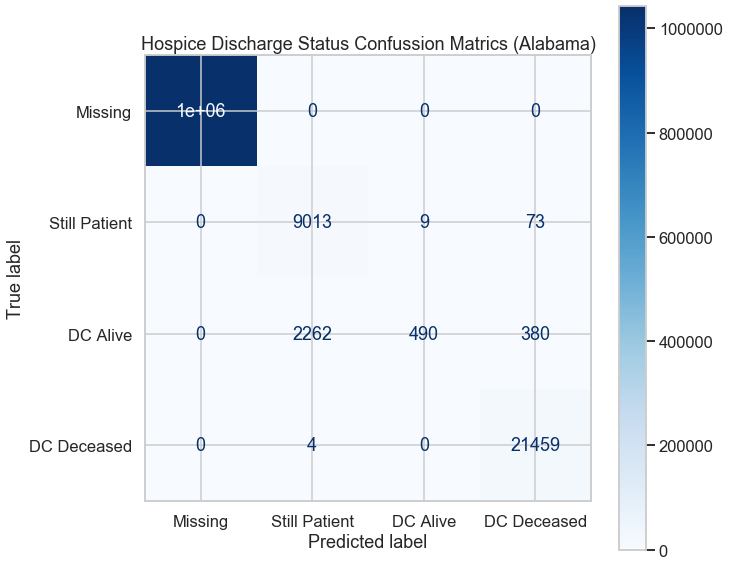

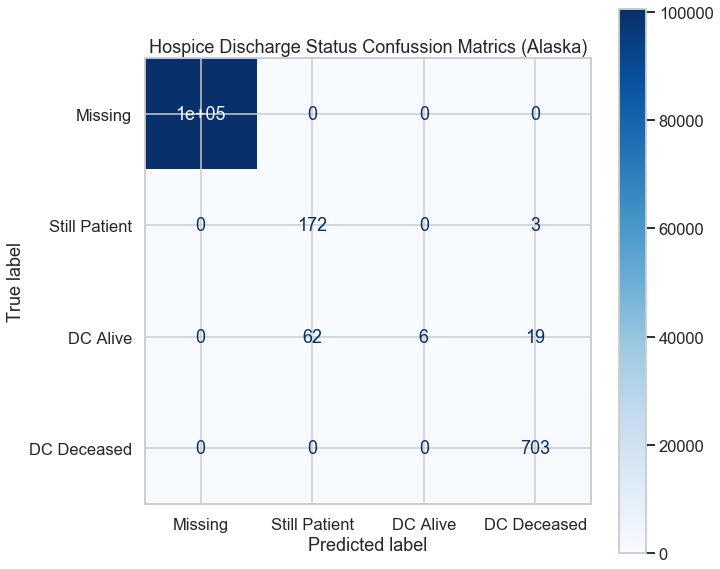

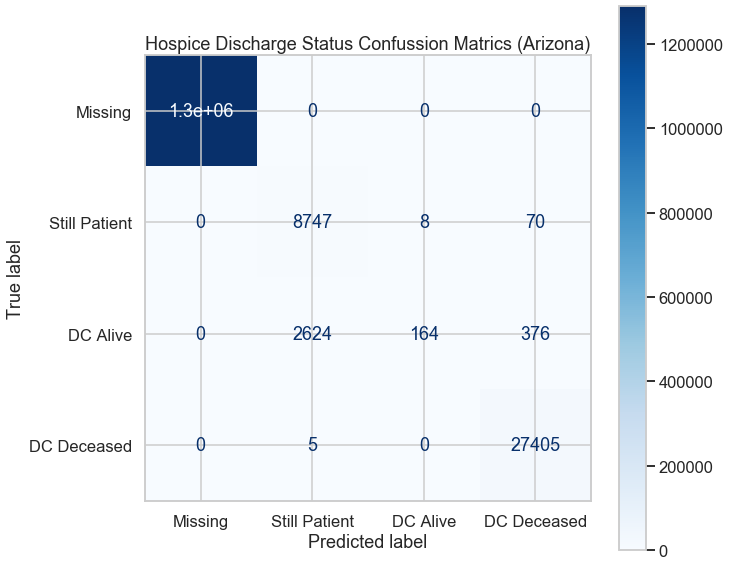

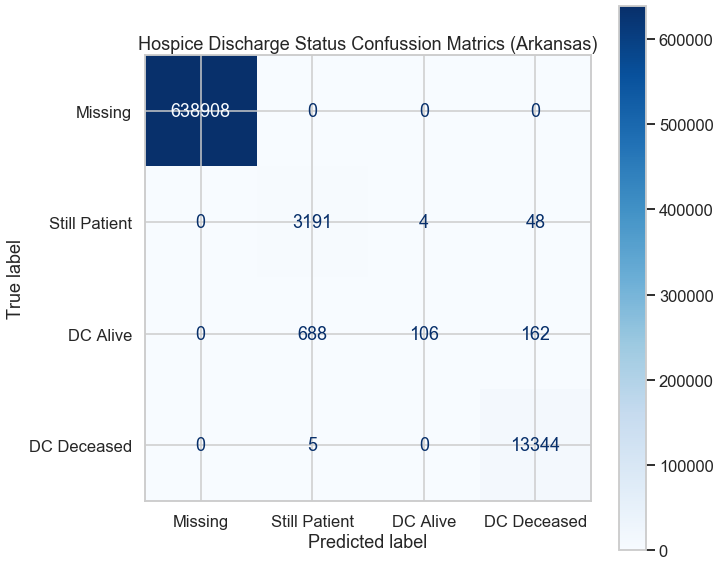

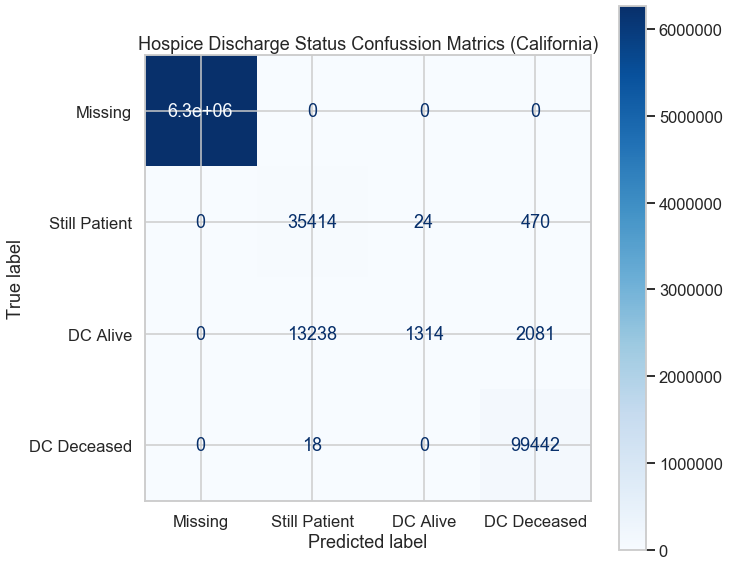

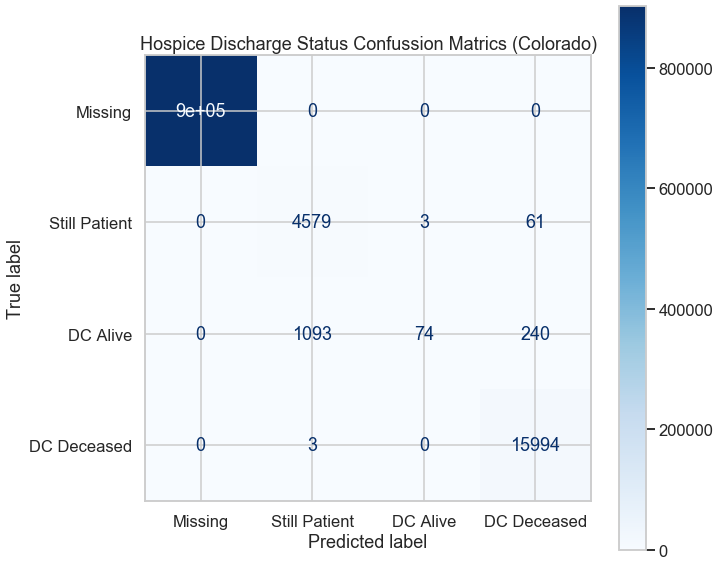

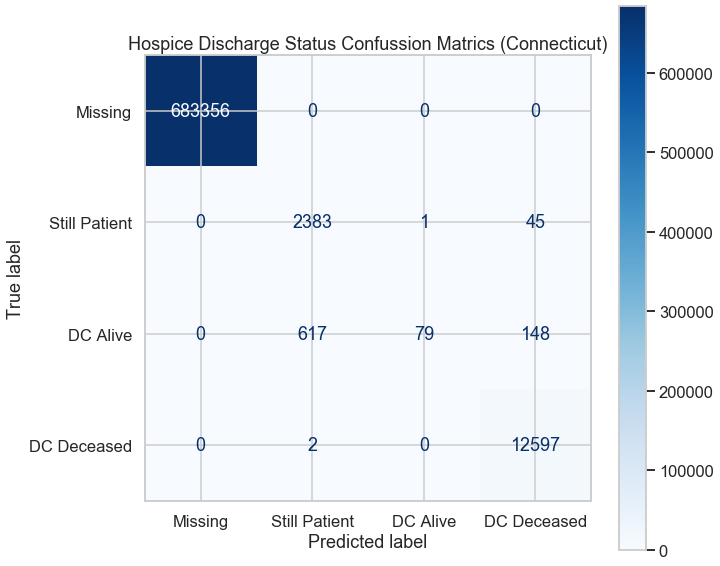

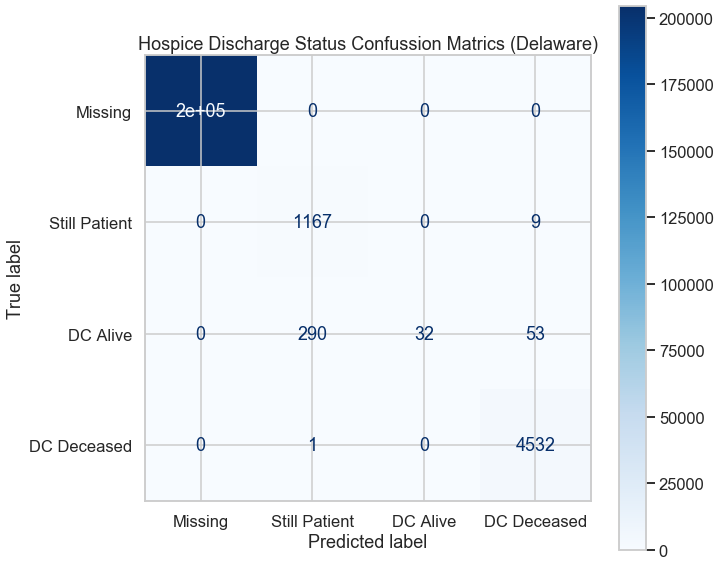

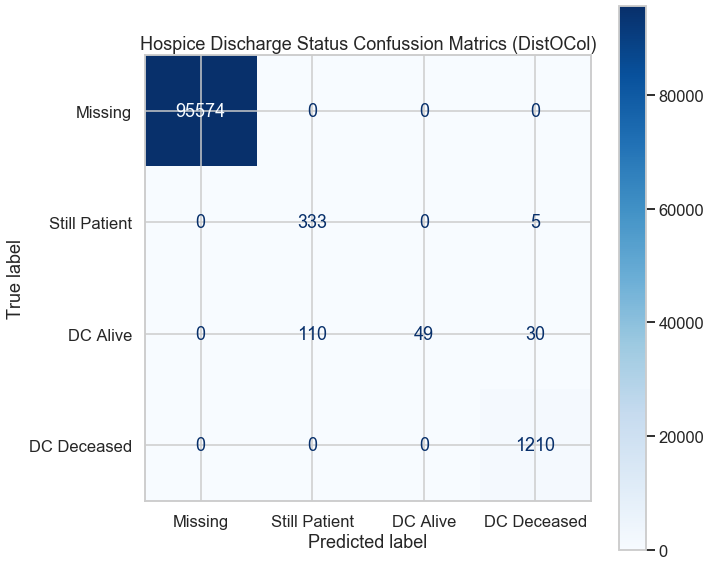

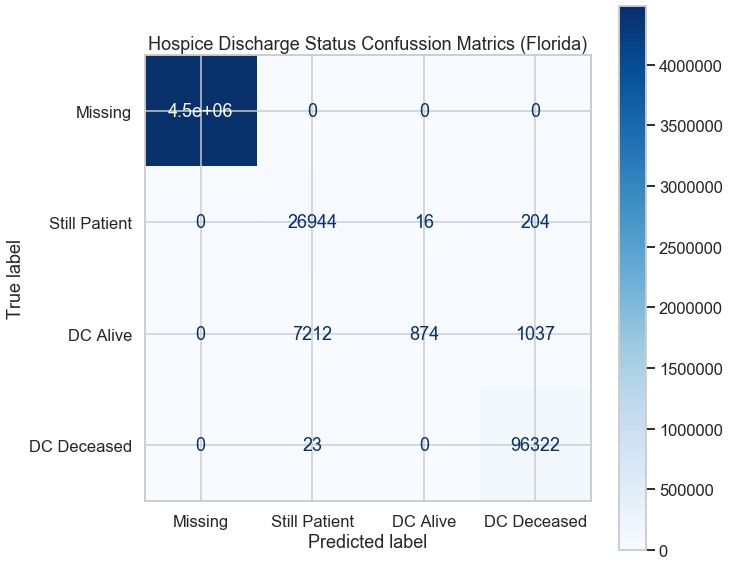

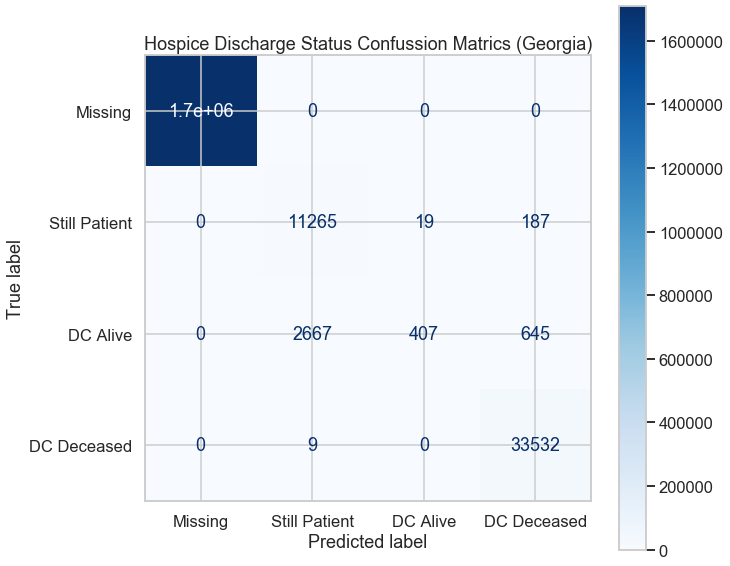

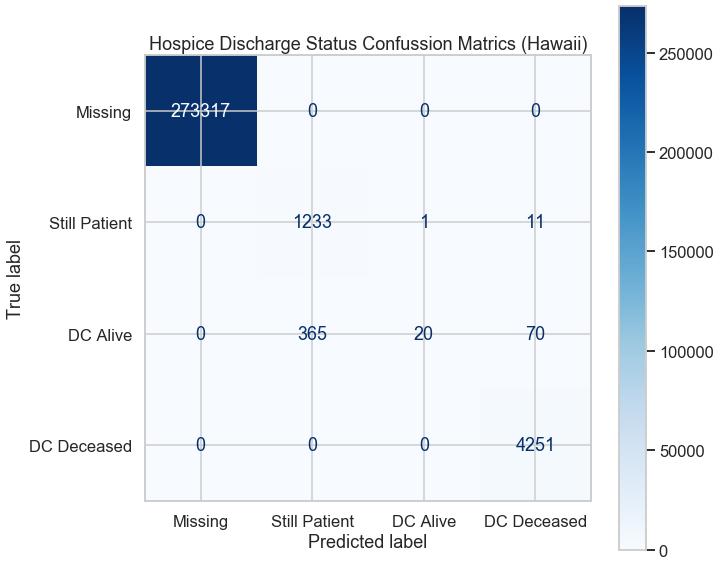

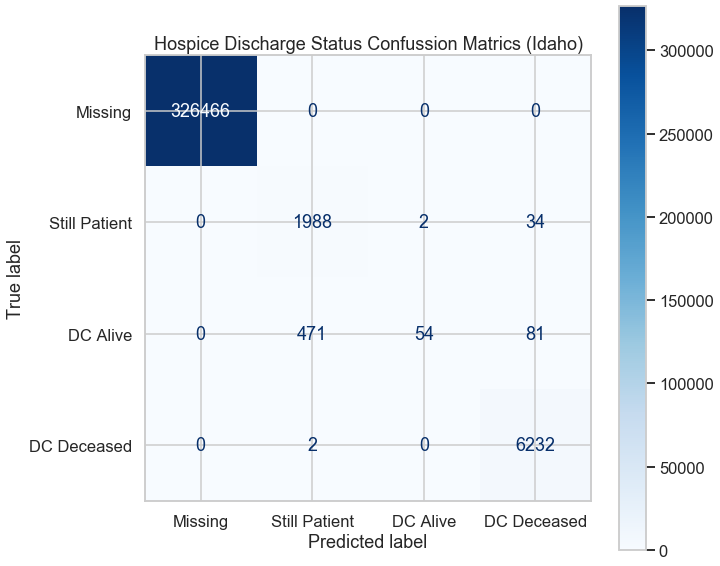

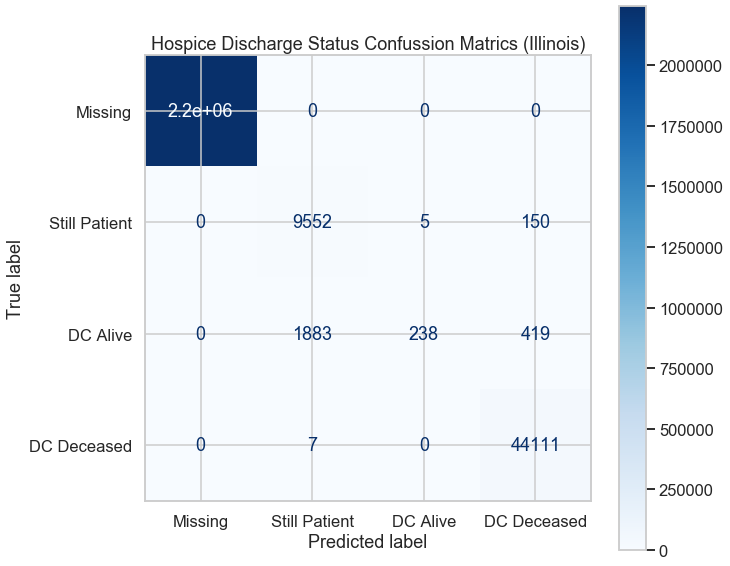

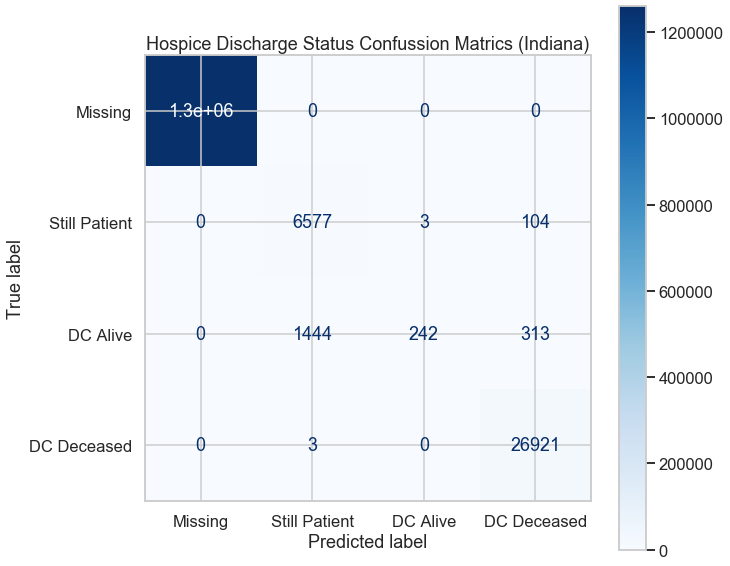

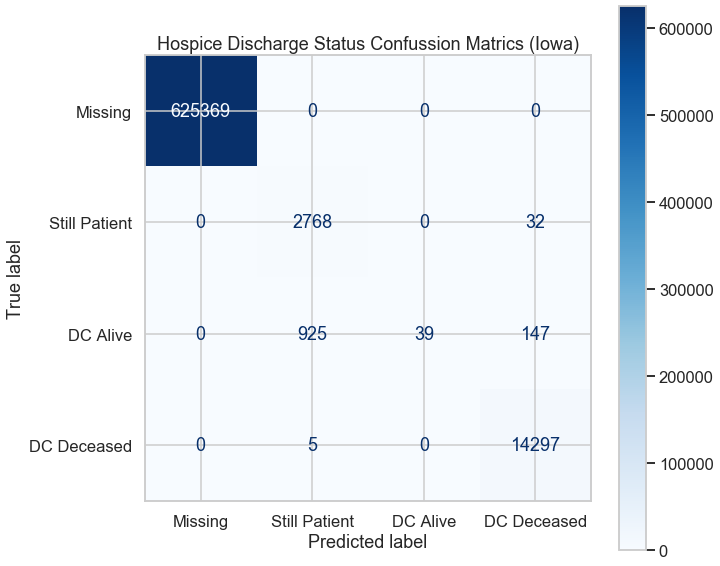

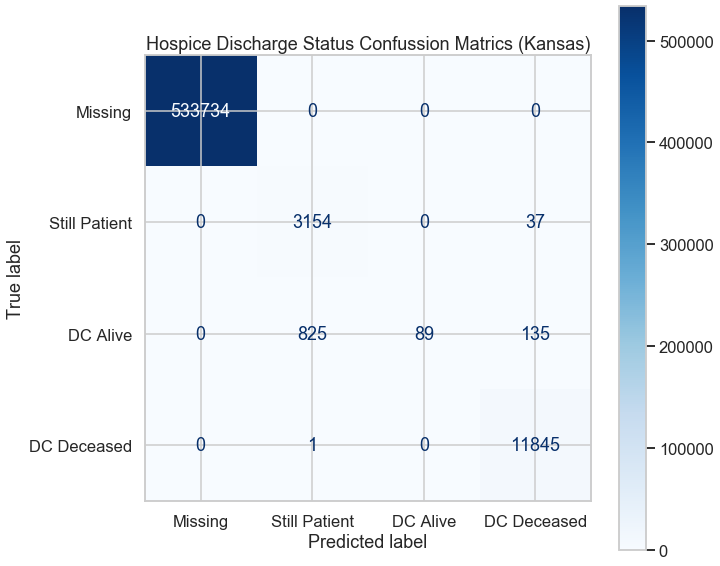

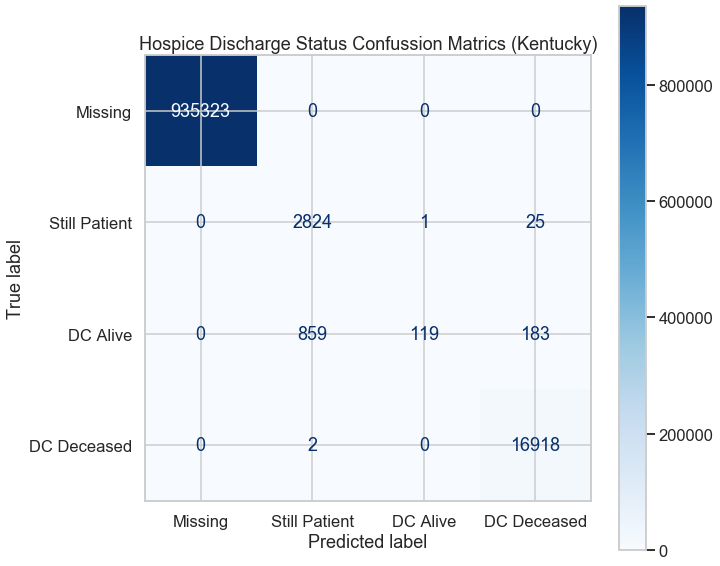

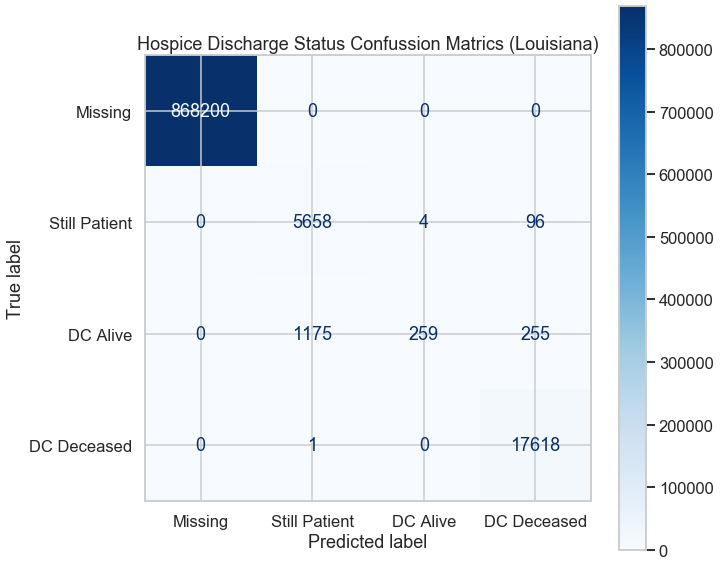

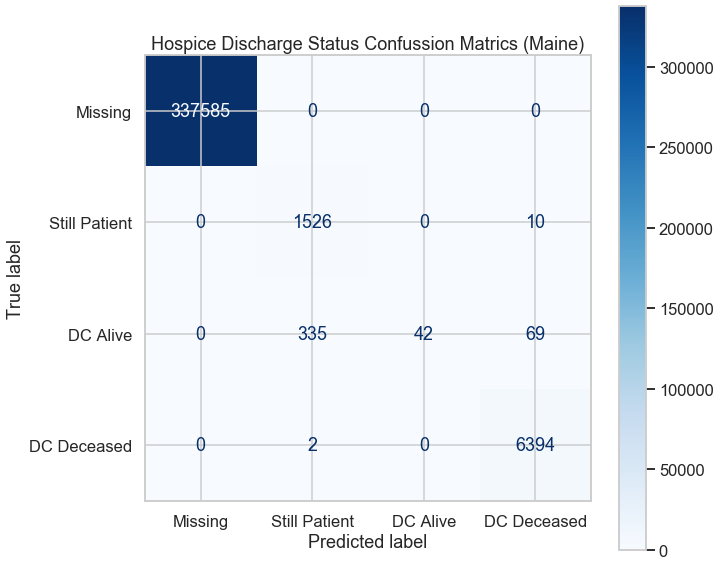

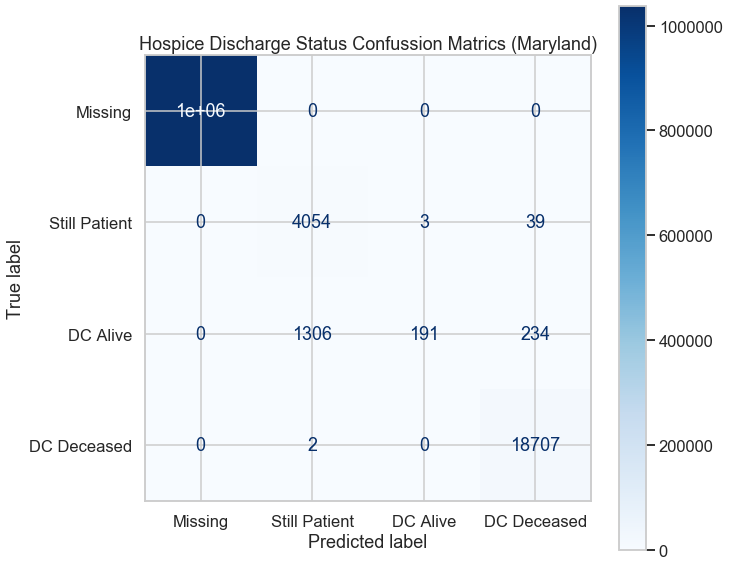

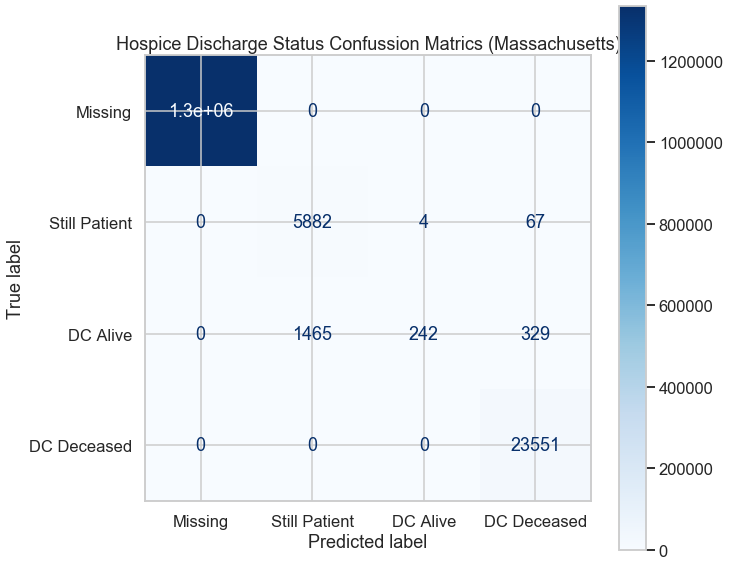

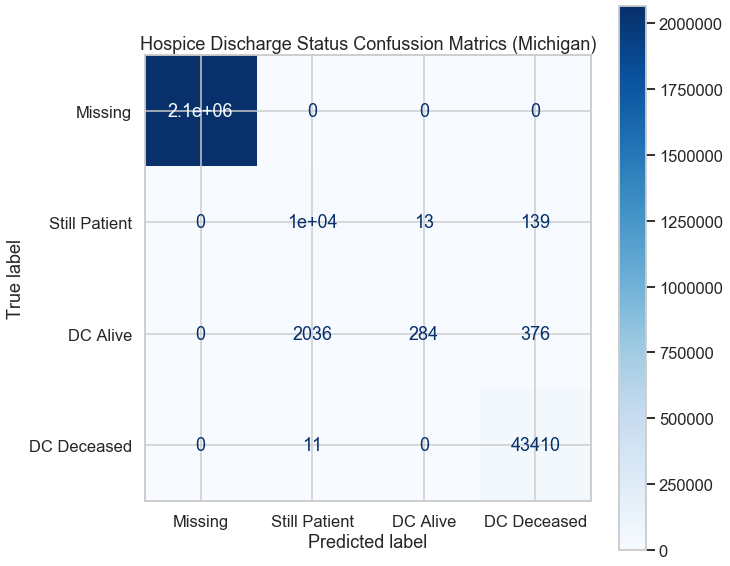

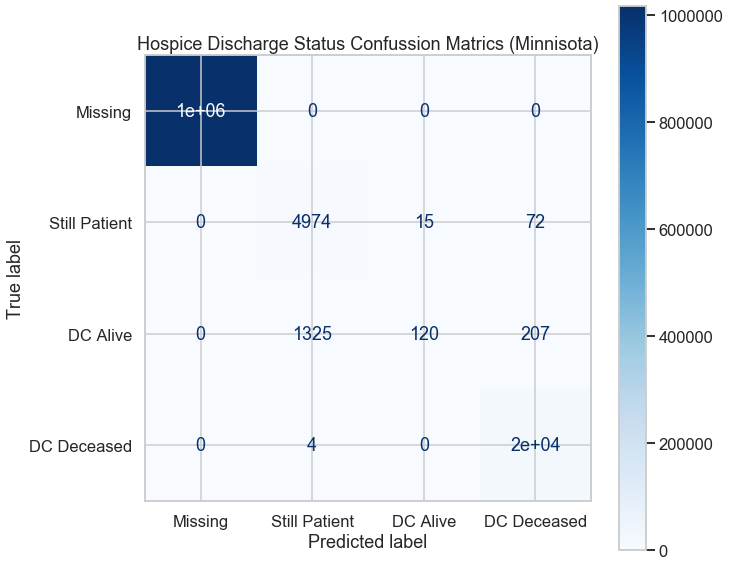

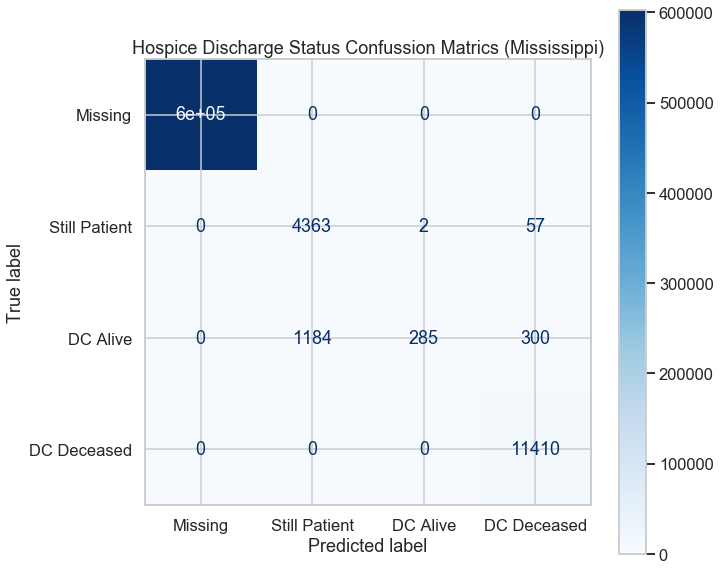

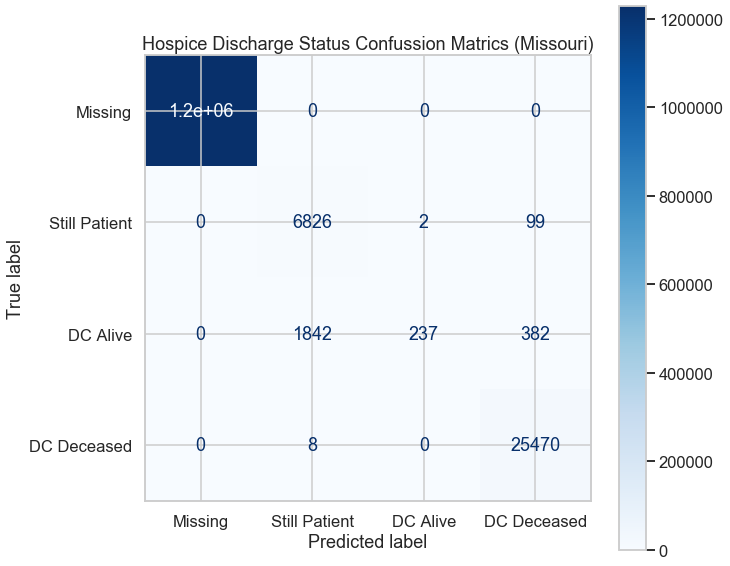

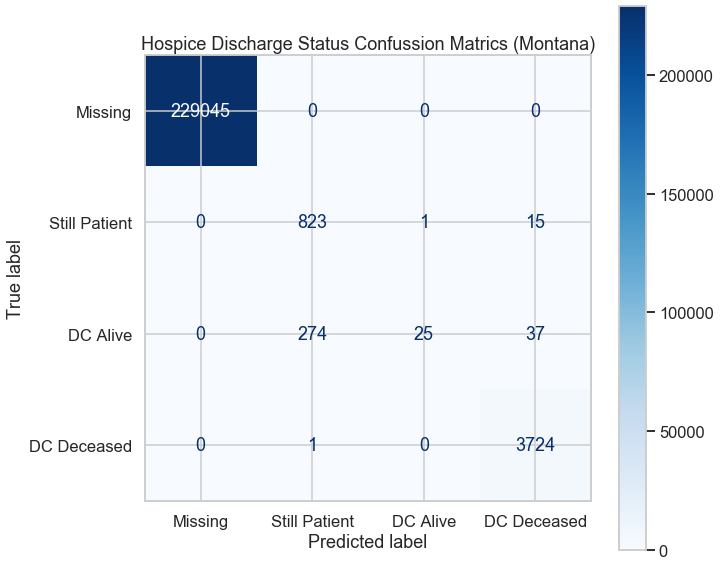

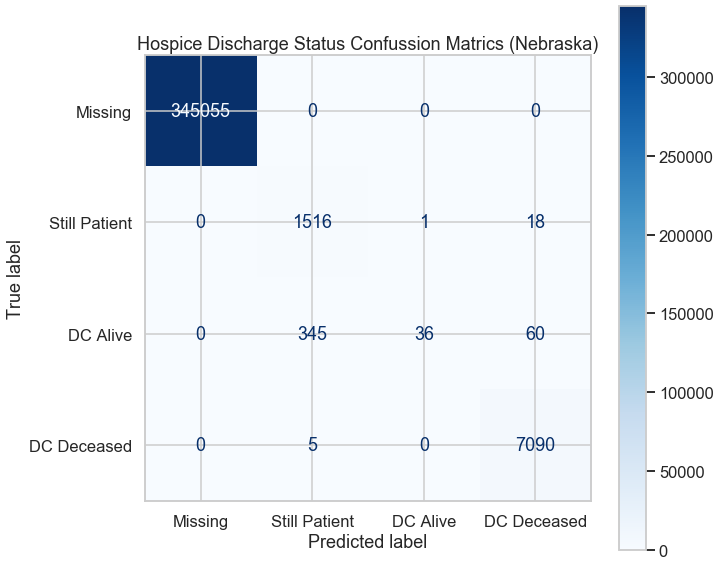

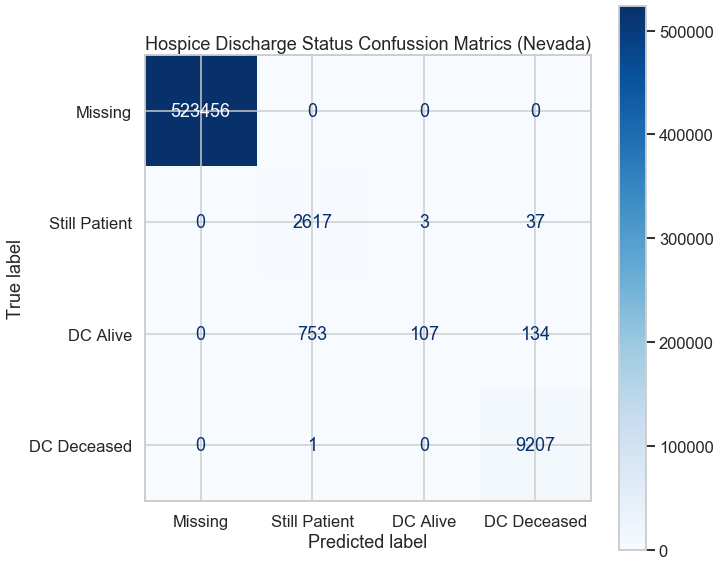

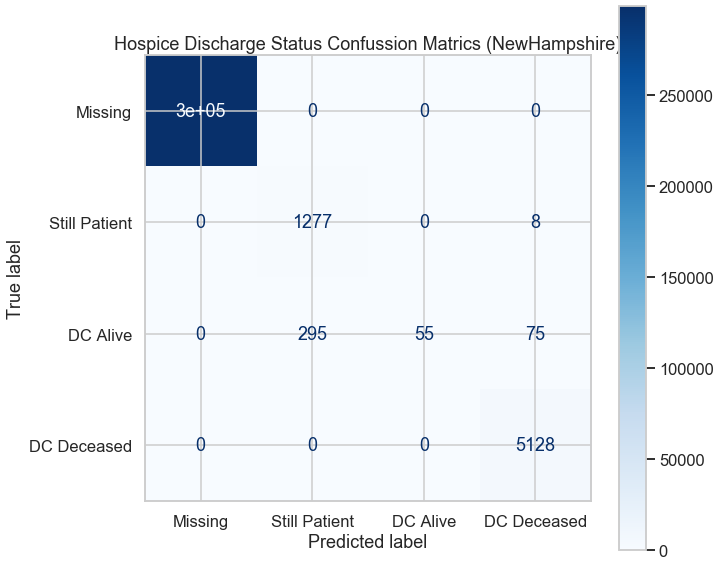

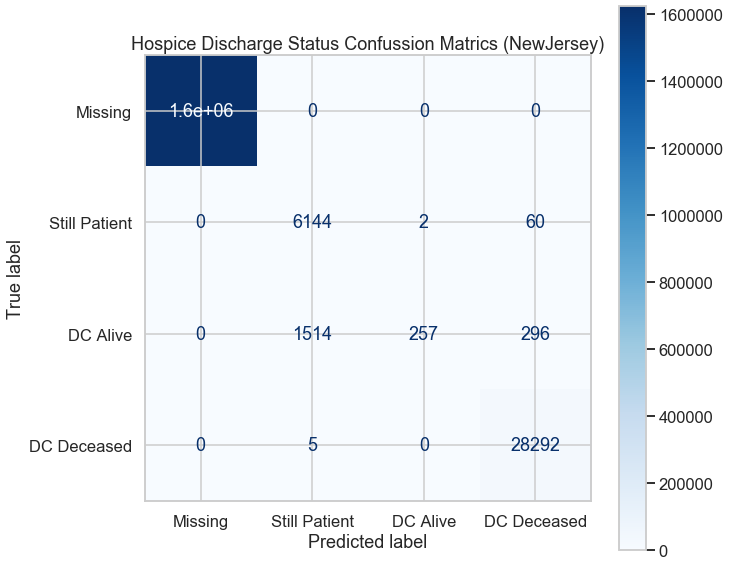

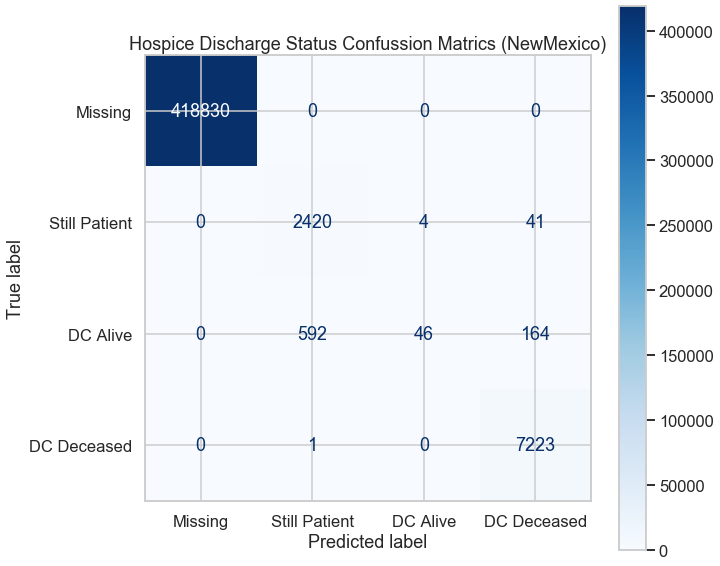

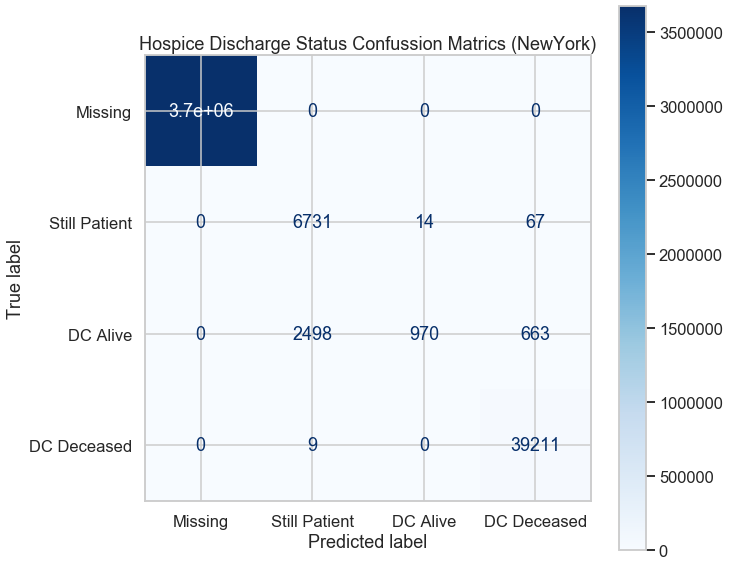

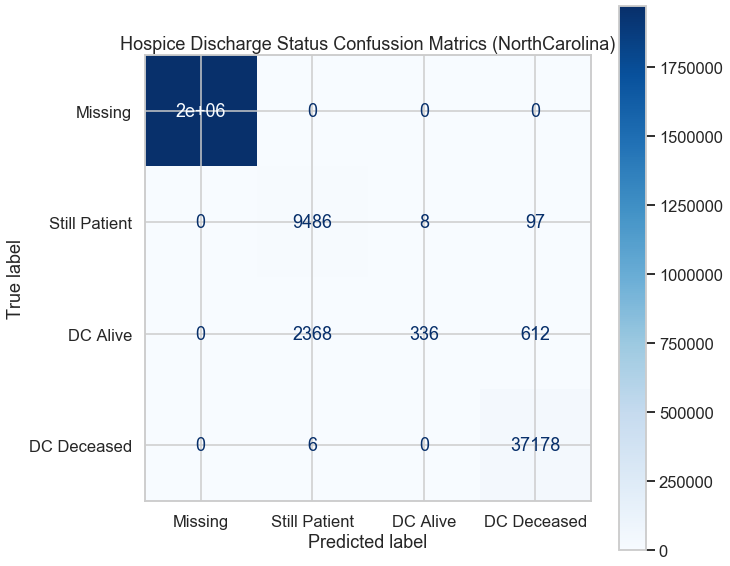

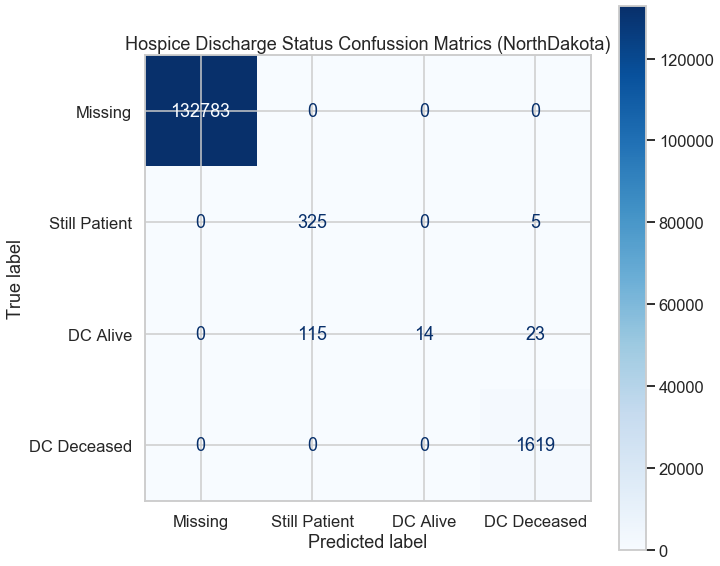

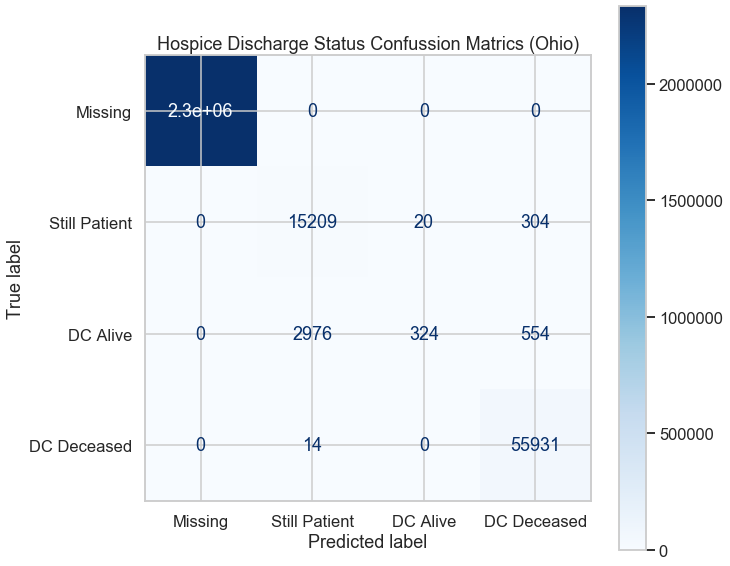

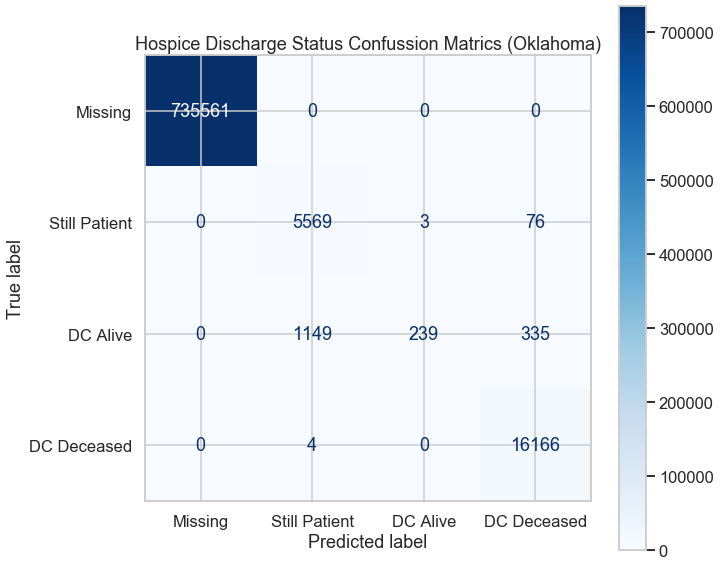

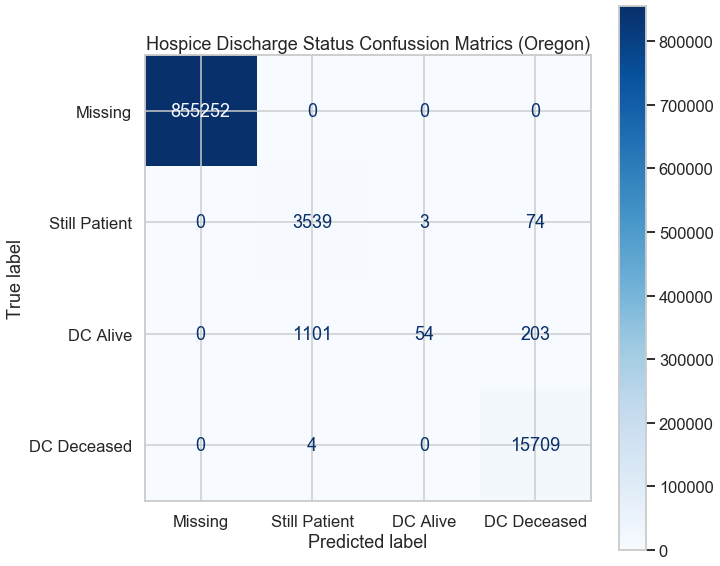

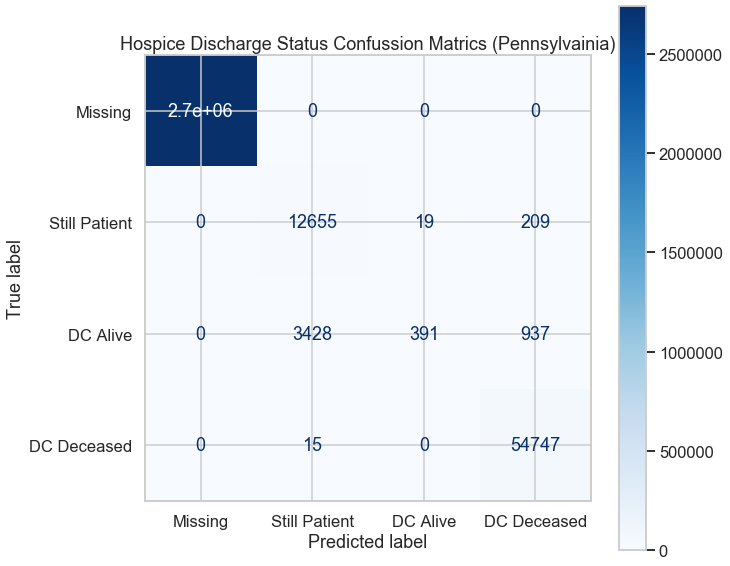

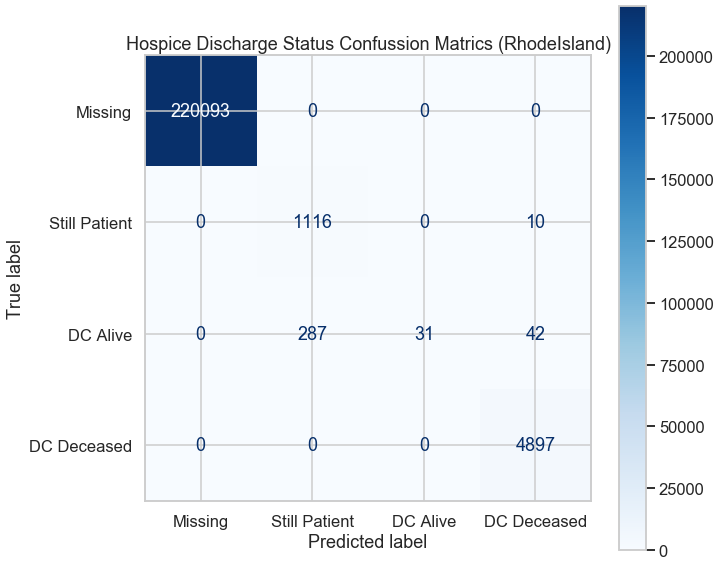

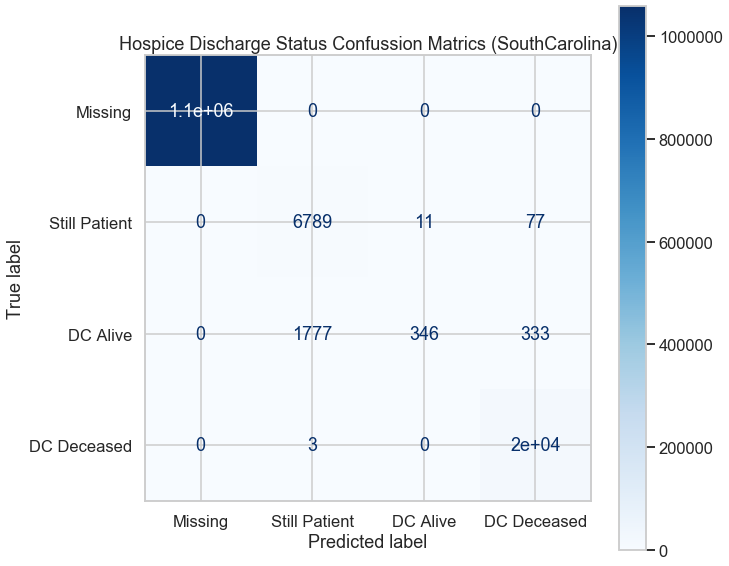

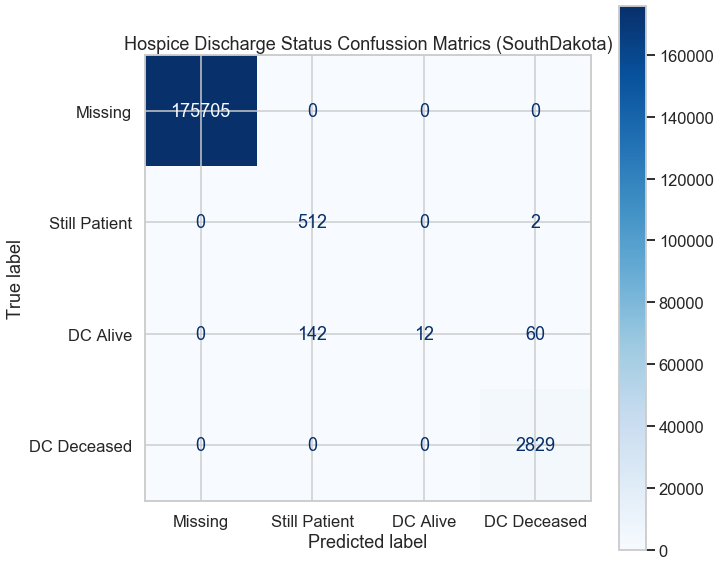

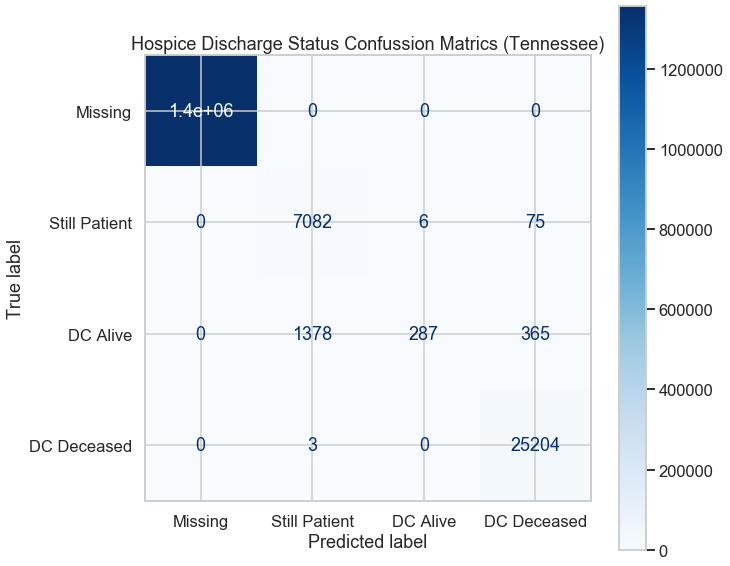

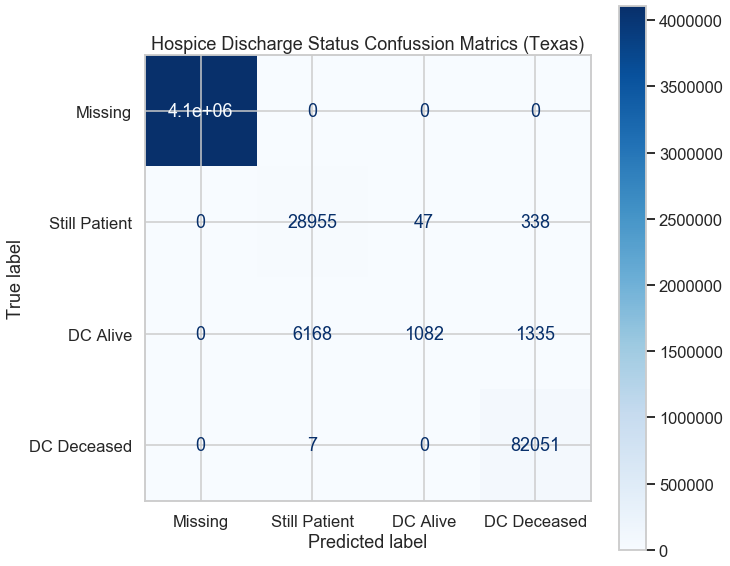

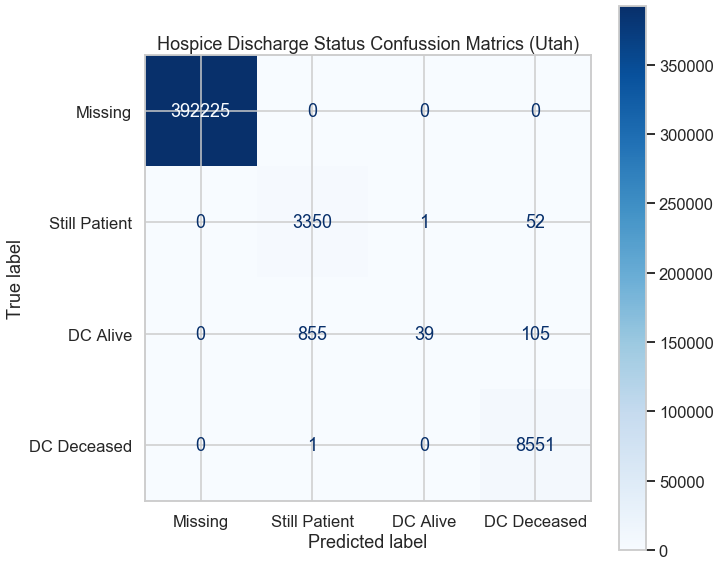

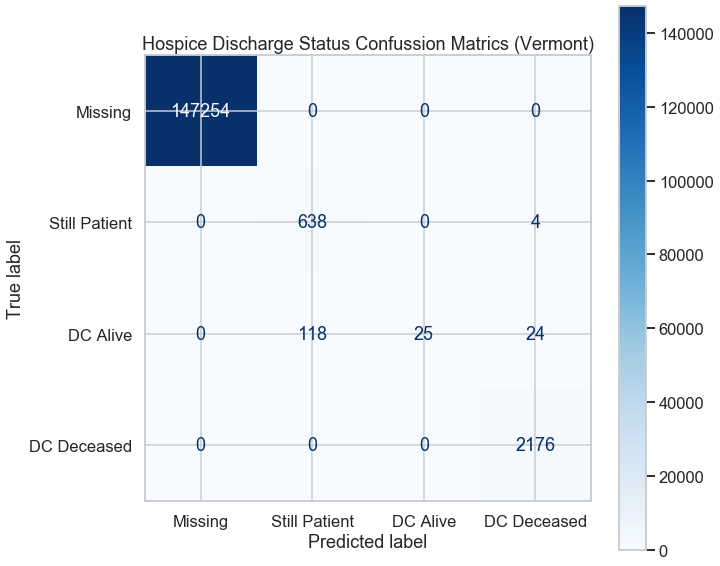

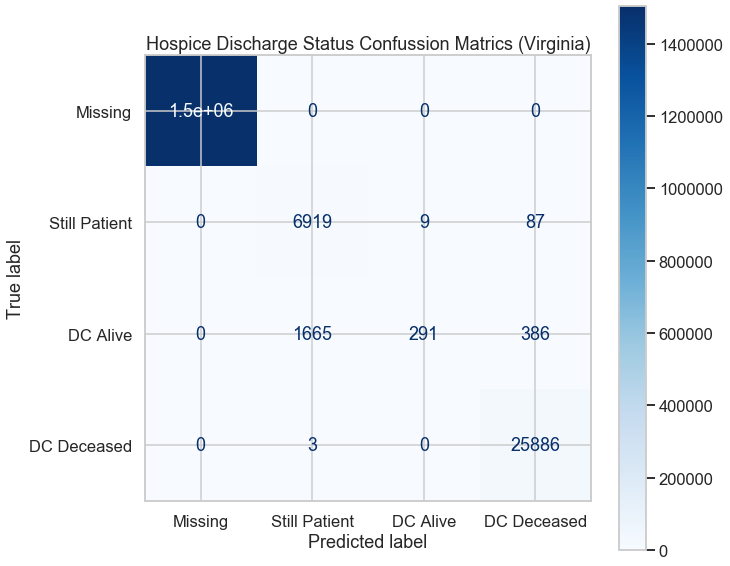

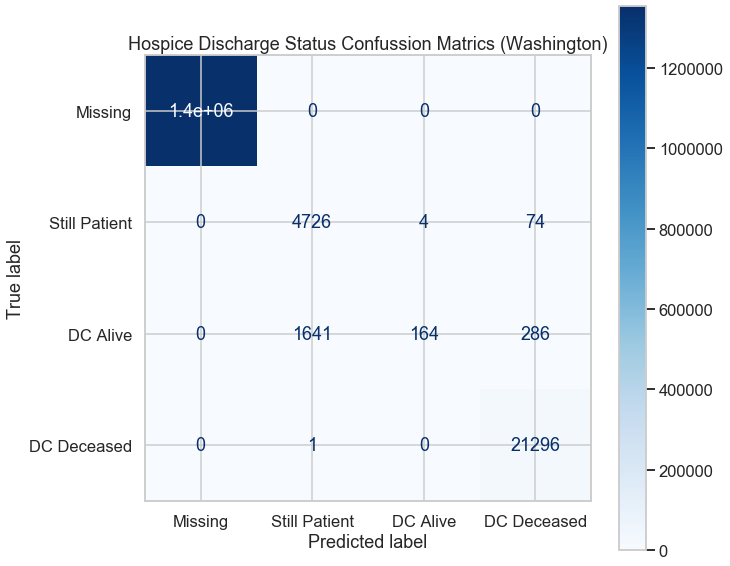

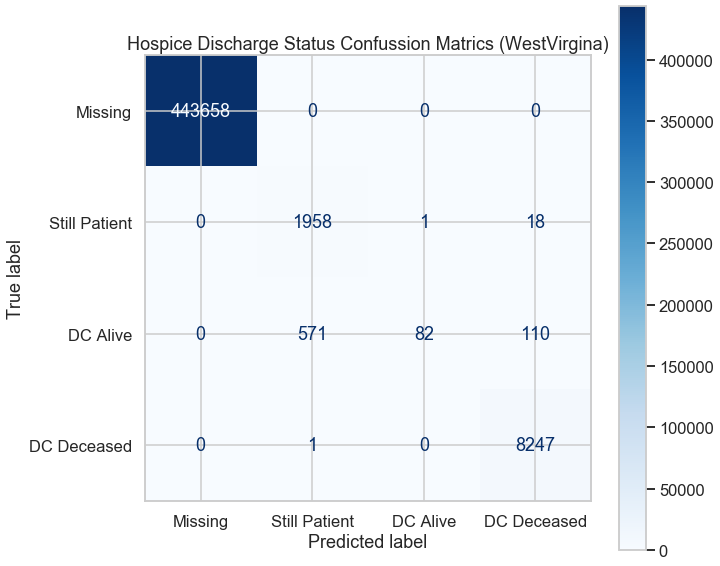

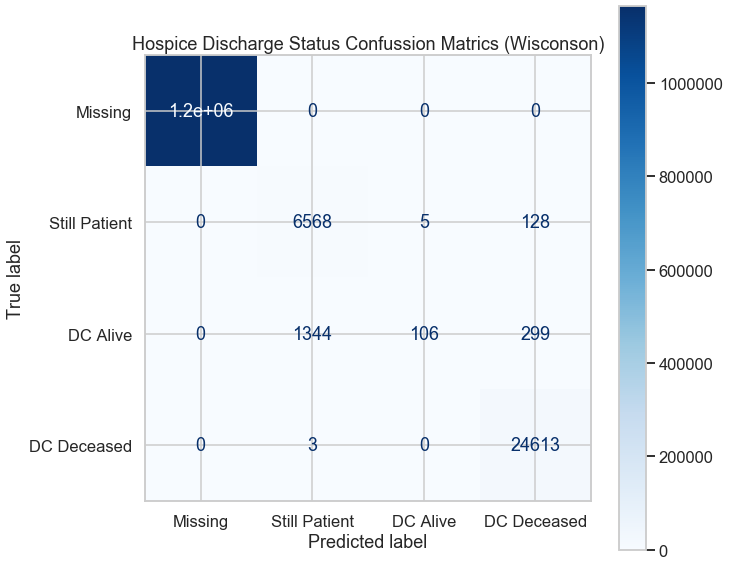

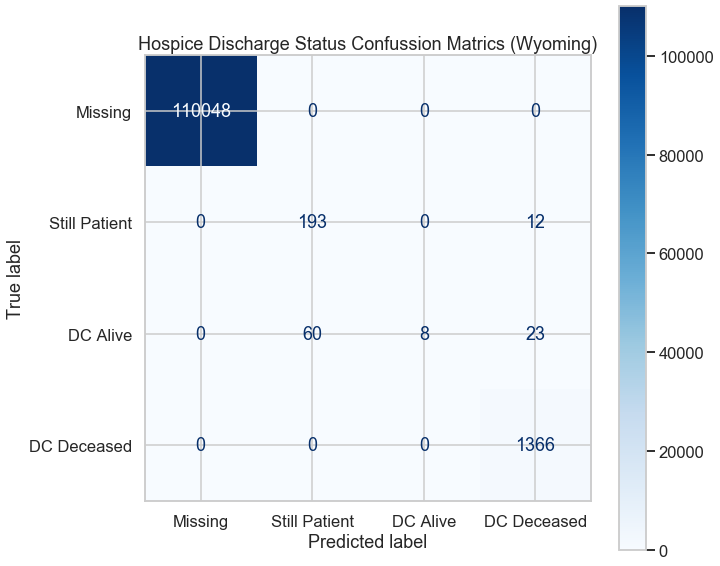

In [59]:
# Set the location of the figure
figPath = 'e:/PatrickBernard/hosDischarge/'
# Retrieve the model
model_dis = pickle.load(open(f'{figPath}rf_model_discharge.mdl','rb'))

for file in os.listdir(f'e:/PatrickBernard/'):
    if file.endswith('.pkl')== False:
        continue
    else:
        with open(f'e:/PatrickBernard/{file}', 'rb') as f:
            regional_data = pickle.load(f)
    print(file)
    # Retrieve the state identifier
    s = regional_data.iloc[0,1]
    
    # impute missing data
    regional_data.fillna(-999, inplace = True)
    # Create a random number for confounding
    regional_data['RANDOM_NUM'] = randint(0, 10)    
    

    #define the features
    feat_r = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Race','D_Age','D_TM', 'D_TM_Died',
            'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY',
            'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
            'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
            'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days','RANDOM_NUM']

    regional_data['PRED_HOS_PTDCSTUS'] = model_dis.predict(regional_data[feat_r])
    
    plot_confusion_matrix(model_dis, regional_data[features], regional_data['D_HOS_PTDCSTUS'],
                                 display_labels=PTDCSTUS.values(),
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    plt.title(f'Hospice Discharge Status Confussion Matrics ({states[s]})')
    plt.savefig(f'{figPath}{states[s]}_DischargeStatusConfussionMatrics.png',bbox_inches = 'tight')
    plt.close()  # Added to correct warning in the results
    nn= file[:-4]
    regional_data.to_csv(f'{figPath}pred_{nn}.csv',index=False)

### Classify on Race

If we use the ussage features in the data can we determine the race of the individual?  

In [85]:

feat_r = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Age','D_TM', 'D_TM_Died',
            'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY','D_HOS_PTDCSTUS',
            'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
            'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
            'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days','N_Providers']

labels_r = ['D_Race']

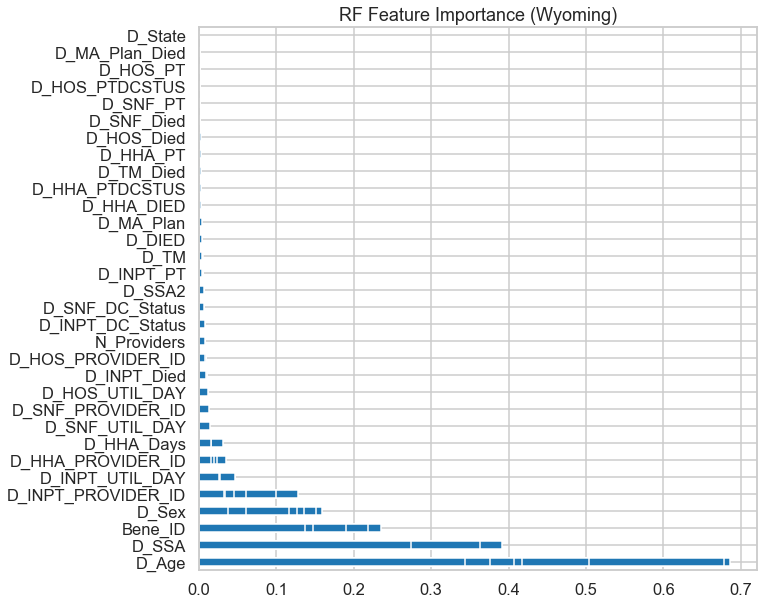

In [143]:

# Set the location of the figure
figPath = 'e:/PatrickBernard/figures/RF_Class/'


for file in os.listdir(f'e:/PatrickBernard/'):
    if file.endswith('.pkl'))== False:
        continue
    else:
        with open(f'e:/PatrickBernard/{file}', 'rb') as f:
            regional_data = pickle.load(f)

    # Retrieve the state identifier
    s = regional_data.iloc[0,1]
    
    # impute missing data
    regional_data.fillna(-999, inplace = True)
    # Create a random number of confounding
    regional_data['RANDOM_NUM'] = randint(0, 10)
    

    #define the features
    feat_r = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Age','D_TM', 'D_TM_Died',
                'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY','D_HOS_PTDCSTUS',
                'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
                'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
                'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days','N_Providers','RANDOM_NUM']

    #labels_r = ['D_Race']


    # build the training and test data sets
    X_data = regional_data[feat_r]
    y_data = regional_data['D_Race']

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3) # 70% training 30% test

    # Define the model
    model_r = RandomForestClassifier(n_estimators=100, max_depth = 6, min_samples_leaf = 3)

    # fit the model to predict on Hospice discharge status
    model_r.fit(X_train,y_train)
    
    regional_data['Race_pred'] = model_r.predict(regional_data[feat_r])

    feat_importances = pd.Series(model_r.feature_importances_, regional_data[feat_r].columns)
    feat_importances.nlargest(32).plot(kind='barh')
    plt.title(f'RF Feature Importance ({states[s]})')
    plt.savefig(f'{figPath}{states[s]}_RF_FeatureImportance.png',bbox_inches = 'tight')
    feat_importances['state'] =  states[s]



 # Create a classifiation utilization summary file with data for all the states
    
    s_data = {'state':states[s], 'Tot_record':len(regional_data)}

#     race_count = regional_data.groupby('Race_pred')['Race_pred'].count()

#     sum_Race = {'Pred_unk_tot' : race_count[0], 'Pred_white_tot': race_count[1],'Pred_black_tot':race_count[2],'Pred_other_tot':race_count[3],
#                 'Pred_asian_tot': race_count[4], 'Pred_Hispanic_tot': race_count[5], 'Pred_NA_Native_tot': race_count[6]}

#     s_data.update(sum_Race)

    for i in range (0, 7):
        z_data = {f'Pred_{Race[i]}_alive': len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_DIED == 0)].index),
        f'Pred_{Race[i]}_deceased' : len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_DIED == 1)].index),
        f'Pred_{Race[i]}_HOS_alive' : len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_HOS_Died == 0)].index),
        f'Pred_{Race[i]}_HOS_deceased' : len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_HOS_Died == 1)].index)}
        
        if z_data[f'Pred_{Race[i]}_deceased'] == 0:
            util = {f'Pred_{Race[i]}_HOS_Utilization' : 0}
        else:
            util = {f'Pred_{Race[i]}_HOS_Utilization' : z_data[f'Pred_{Race[i]}_HOS_deceased']/z_data[f'Pred_{Race[i]}_deceased']}
            
        z_data.update(util)
        s_data.update(z_data)
        

    cols = ['state', 'Tot_record','Pred_Unknown_alive','Pred_Unknown_deceased','Pred_Unknown_HOS_alive', 'Pred_Unknown_HOS_deceased', \
            'Pred_Unknown_HOS_Utilization',  \
            'Pred_White_alive','Pred_White_deceased', 'Pred_White_HOS_alive', 'Pred_White_HOS_deceased','Pred_White_HOS_Utilization', \
            'Pred_Black_alive','Pred_Black_deceased', 'Pred_Black_HOS_alive','Pred_Black_HOS_deceased', 'Pred_Black_HOS_Utilization', \
            'Pred_Other_alive','Pred_Other_deceased', 'Pred_Other_HOS_alive', 'Pred_Other_HOS_deceased', 'Pred_Other_HOS_Utilization', \
            'Pred_Asian_alive','Pred_Asian_deceased', 'Pred_Asian_HOS_alive', 'Pred_Asian_HOS_deceased', 'Pred_Asian_HOS_Utilization', \
            'Pred_Hispanic_alive','Pred_Hispanic_deceased', 'Pred_Hispanic_HOS_alive','Pred_Hispanic_HOS_deceased', \
            'Pred_Hispanic_HOS_Utilization', \
            'Pred_North_American_Native_alive','Pred_North_American Native_deceased', 'Pred_North_American_Native_HOS_alive', \
            'Pred_North_American_Native_HOS_deceased','Pred_North_American_Native_HOS_Utilization']

    # Open the pickle file and append the classification dictionary to the file
    #TODO once all of the column are identified in the summary data order the data for clarity in the dataframe

    try:
        with open(f'e:/PatrickBernard/figures/RF_Class/RF_data.pkl', 'rb') as f:
                    RF_data = pickle.load(f)
    except (OSError, IOError) as e:
        RF_data = pd.DataFrame(columns = cols)

    RF_data = RF_data.append(s_data, ignore_index=True)
    with open(f'e:/PatrickBernard/figures/RF_Class/RF_data.pkl', 'wb') as f:
            pickle.dump(RF_data, f)

    # Save the RF Feature Importance data
  
    try:
        with open(f'e:/PatrickBernard/figures/RF_Class/RF_FeatImportance.pkl', 'rb') as f:
                        RF_FeatImportance = pickle.load(f)
    except (OSError, IOError) as e:
            RF_FeatImportance = pd.DataFrame()

    RF_FeatImportance = RF_FeatImportance.append(feat_importances, ignore_index=True)
    with open(f'e:/PatrickBernard/figures/RF_Class/RF_FeatImportance.pkl', 'wb') as f:
            pickle.dump(RF_FeatImportance, f)

**Retrieve summary data and plot the results**  

In [3]:
with open(f'e:/PatrickBernard/figures/RF_Class/RF_data.pkl', 'rb') as f:
                summary_data = pickle.load(f)

In [4]:
summary_data


,state,Tot_record,Pred_Unknown_alive,Pred_Unknown_deceased,Pred_Unknown_HOS_alive,Pred_Unknown_HOS_deceased,Pred_Unknown_HOS_Utilization,Pred_White_alive,Pred_White_deceased,Pred_White_HOS_alive,...,Pred_Hispanic_deceased,Pred_Hispanic_HOS_alive,Pred_Hispanic_HOS_deceased,Pred_Hispanic_HOS_Utilization,Pred_North_American_Native_alive,Pred_North_American Native_deceased,Pred_North_American_Native_HOS_alive,Pred_North_American_Native_HOS_deceased,Pred_North_American_Native_HOS_Utilization,Pred_North_American_Native_deceased
0,Louisiana,893266,0,0,0,0,0,856017,35244,7434,...,0,0,0,0,0,NaN,0,0,0,0.0
1,Louisiana,893266,0,0,0,0,0,855965,35269,7435,...,0,0,0,0,0,NaN,0,0,0,0.0
2,Alabama,1075991,0,0,0,0,0,1032359,43632,12224,...,0,0,0,0,0,NaN,0,0,0,0.0
3,Alaska,101528,0,0,0,0,0,97208,2844,258,...,0,0,0,0,1248,NaN,4,12,0.0526316,228.0
4,Arizona,1329276,0,0,0,0,0,1281363,46377,11983,...,0,0,0,0,1391,NaN,0,0,0,145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Washington,1382710,0,0,0,0,0,1336386,46324,6893,...,0,0,0,0,0,NaN,0,0,0,0.0
59,WestVirgina,454646,0,0,0,0,0,435705,18941,2740,...,0,0,0,0,0,NaN,0,0,0,0.0
60,Wisconson,1197874,0,0,0,0,0,1153062,44812,8447,...,0,0,0,0,0,NaN,0,0,0,0.0
61,Wyoming,111710,0,0,0,0,0,107605,4105,296,...,0,0,0,0,0,NaN,0,0,0,0.0


In [5]:
summary_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pred_White_HOS_Utilization,63.0,0.510417,0.111941,0.242968,0.467589,0.49949,0.533657,0.888889
Pred_Black_HOS_Utilization,63.0,0.050552,0.149513,0.000000,0.000000,0.00000,0.000000,1.000000
Pred_North_American Native_deceased,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pred_North_American_Native_deceased,63.0,6.047619,33.779374,0.000000,0.000000,0.00000,0.000000,228.000000


In [147]:
col1 = ['Tot_record',  'Pred_Unknown_alive','Pred_Unknown_deceased', 'Pred_Unknown_HOS_alive', 'Pred_Unknown_HOS_deceased', 'Pred_White_alive',
        'Pred_White_deceased', 'Pred_White_HOS_alive', 'Pred_White_HOS_deceased', 'Pred_Black_alive','Pred_Black_deceased',
        'Pred_Black_HOS_alive',
        'Pred_Black_HOS_deceased', 'Pred_Other_alive','Pred_Other_deceased', 'Pred_Other_HOS_alive', 'Pred_Other_HOS_deceased', 'Pred_Asian_alive',
        'Pred_Asian_deceased', 'Pred_Asian_HOS_alive', 'Pred_Asian_HOS_deceased', 'Pred_Hispanic_alive','Pred_Hispanic_deceased', 'Pred_Hispanic_HOS_alive',
        'Pred_Hispanic_HOS_deceased','Pred_North_American_Native_HOS_alive', 'Pred_North_American_Native_HOS_deceased',
        'Pred_North_American_Native_alive', 'Pred_North_American_Native_deceased']
col2 = ['Pred_Unknown_HOS_Utilization','Pred_White_HOS_Utilization','Pred_Black_HOS_Utilization','Pred_Other_HOS_Utilization','Pred_Asian_HOS_Utilization',
        'Pred_Hispanic_HOS_Utilization','Pred_North_American_Native_HOS_Utilization']

summary_data[col1] = summary_data[col1].astype(int)
summary_data[col2] = summary_data[col2].astype(float)
summary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 38 columns):
state                                         63 non-null object
Tot_record                                    63 non-null int32
Pred_Unknown_alive                            63 non-null int32
Pred_Unknown_deceased                         63 non-null int32
Pred_Unknown_HOS_alive                        63 non-null int32
Pred_Unknown_HOS_deceased                     63 non-null int32
Pred_Unknown_HOS_Utilization                  63 non-null float64
Pred_White_alive                              63 non-null int32
Pred_White_deceased                           63 non-null int32
Pred_White_HOS_alive                          63 non-null int32
Pred_White_HOS_deceased                       63 non-null int32
Pred_White_HOS_Utilization                    63 non-null float64
Pred_Black_alive                              63 non-null int32
Pred_Black_deceased                           63 non-null in

In [ ]:
summary_data

In [6]:
# TODO determine why there are duplicate columns (solved)
summary_data.drop_duplicates(subset=None, keep='first', inplace=True)
summary_data['pred_delta_w_b'] =  summary_data['Pred_White_HOS_Utilization'] - summary_data['Pred_Black_HOS_Utilization']

summary_data.sort_values('state',inplace = True)

In [7]:
summary_data.sort_values('pred_delta_w_b', inplace = True)

In [8]:
temp = pd.melt(summary_data, id_vars='state', value_vars=['Pred_White_HOS_Utilization' ,'Pred_Black_HOS_Utilization','pred_delta_w_b'],
               var_name='race', value_name='utilization_percent', col_level=None)

temp['utilization_percent'] = temp['utilization_percent']*100

temp.sample(4)

,state,race,utilization_percent
136,Virginia,pred_delta_w_b,46.458883
16,Montana,Pred_White_HOS_Utilization,45.670836
126,Vermont,pred_delta_w_b,42.919132
128,Kentucky,pred_delta_w_b,43.505091


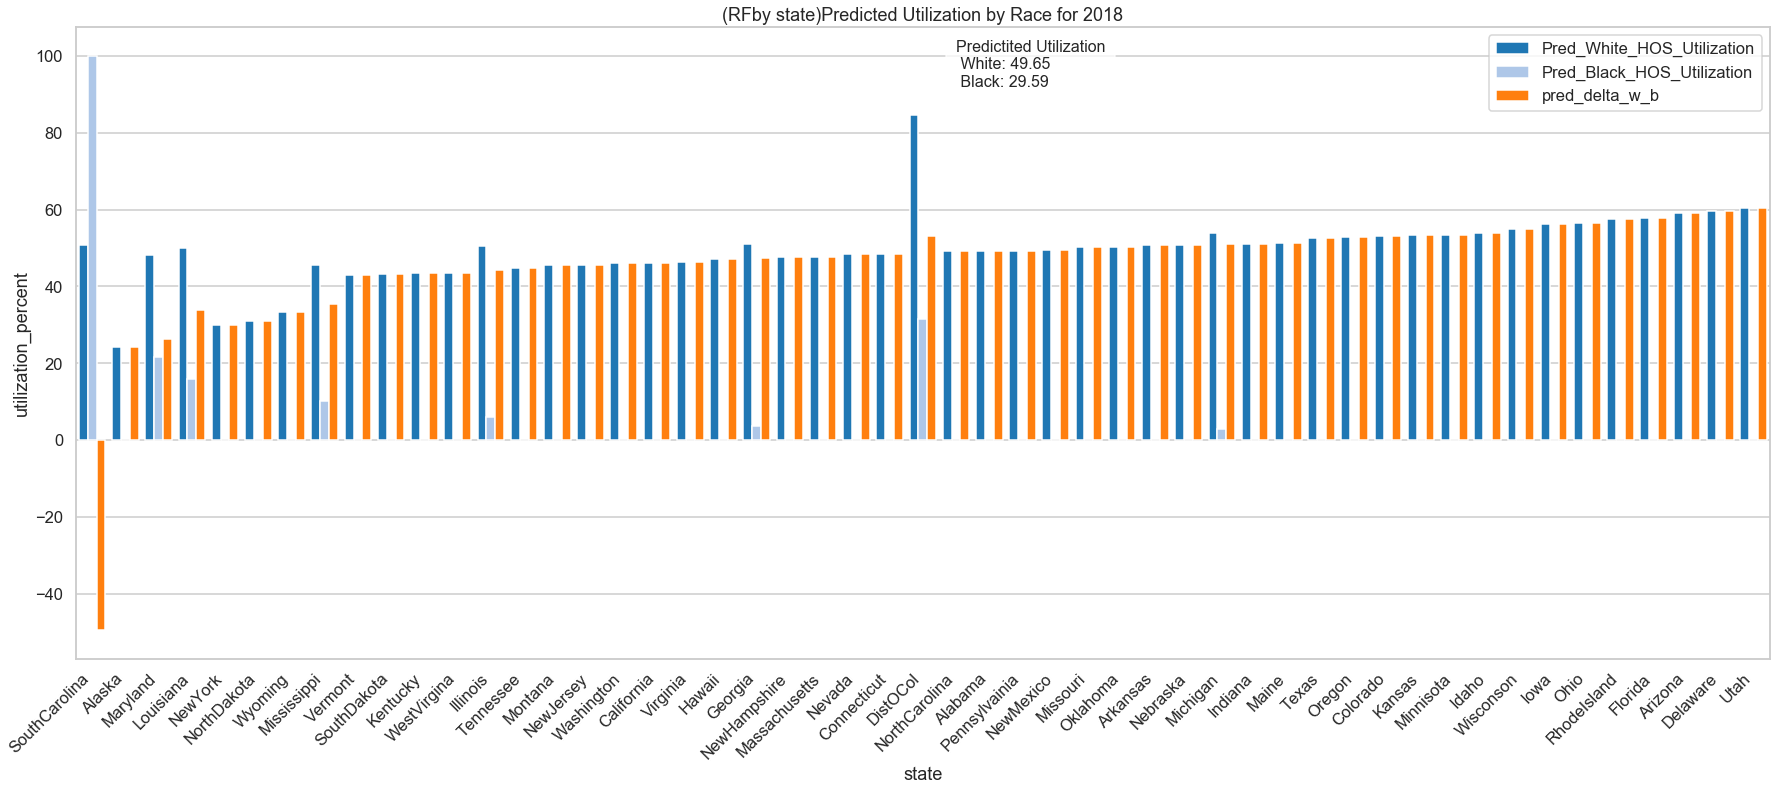

In [28]:
# Calculate the nation utilization numbers
Pred_white_nat_utilisation = summary_data.Pred_White_HOS_deceased.sum() / summary_data.Pred_White_deceased.sum()
Pred_black_nat_utilisation = summary_data.Pred_Black_HOS_deceased.sum() / summary_data.Pred_Black_deceased.sum()

#plot the Figure
plt.figure(figsize=(25,10))
sns.set_context('talk')
sns.set_style('whitegrid')
# create plot
sns.barplot(x = 'state', y ='utilization_percent' ,
            hue = 'race',
            data = temp,
            palette = 'tab20',
            #order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            ci = None,   
            )
plt.text(26,92, f'Predictited Utilization\n White: {round(Pred_white_nat_utilisation*100,2)}\n Black: {round(Pred_black_nat_utilisation*100,2)} ',
         style='normal',bbox={'facecolor':'white', 'alpha':0.75, 'pad':10},fontsize=16)
plt.legend(loc='best')
plt.tight_layout()
plt.title('(RFby state)Predicted Utilization by Race for 2018')
plt.xticks(rotation = 45, ha='right')
plt.savefig(f'e:/PatrickBernard/figures/RF_Class/RFbystate_PredictedUtilizationByState2018.png',bbox_inches = 'tight')

In [15]:
with open(f'e:/PatrickBernard/figures/RF_Class/RF_FeatImportance.pkl', 'rb') as f:
                FeatImport = pickle.load(f)

In [16]:
FeatImport

,Bene_ID,D_Age,D_DIED,D_HHA_DIED,D_HHA_Days,D_HHA_PROVIDER_ID,D_HHA_PT,D_HHA_PTDCSTUS,D_HOS_Died,D_HOS_PROVIDER_ID,...,D_SNF_UTIL_DAY,D_SSA,D_SSA2,D_Sex,D_State,D_TM,D_TM_Died,N_Providers,RANDOM_NUM,state
0,0.019770,0.455124,0.000459,0.002559,0.017365,0.005117,0.002394,0.004685,0.001780,0.003505,...,0.000983,0.306119,0.000027,0.005849,0.0,0.082743,0.000454,0.002731,0.0,Louisiana
1,0.020925,0.438227,0.000314,0.002142,0.019899,0.005807,0.001648,0.005437,0.004992,0.003722,...,0.001204,0.319383,0.000012,0.005012,0.0,0.061639,0.000321,0.002470,0.0,Louisiana
2,0.033482,0.447694,0.000574,0.001099,0.002591,0.005319,0.000886,0.001207,0.002172,0.006245,...,0.001667,0.246634,0.000030,0.007443,0.0,0.093356,0.000681,0.003718,0.0,Alabama
3,0.190300,0.098435,0.001969,0.003247,0.006915,0.011842,0.002374,0.003136,0.000660,0.002166,...,0.002938,0.266749,0.043761,0.007270,0.0,0.005277,0.001964,0.012634,0.0,Alaska
4,0.057586,0.305511,0.000519,0.001960,0.002505,0.003914,0.001823,0.001829,0.003068,0.004533,...,0.002353,0.476931,0.000038,0.005623,0.0,0.045068,0.000496,0.003670,0.0,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.129430,0.248707,0.000600,0.003387,0.005166,0.006930,0.001622,0.002184,0.002940,0.003339,...,0.001891,0.503293,0.000572,0.017800,0.0,0.016196,0.000438,0.012921,0.0,Washington
59,0.120717,0.253413,0.002547,0.001854,0.013903,0.013389,0.001142,0.002387,0.002923,0.006783,...,0.011467,0.417337,0.001493,0.040004,0.0,0.009919,0.001104,0.006967,0.0,WestVirgina
60,0.114758,0.406983,0.000283,0.000218,0.000726,0.004204,0.000202,0.000350,0.001783,0.005414,...,0.001411,0.363063,0.000103,0.021028,0.0,0.021178,0.000255,0.002407,0.0,Wisconson
61,0.147667,0.375496,0.003414,0.002375,0.019508,0.015555,0.001110,0.003177,0.002027,0.006373,...,0.011189,0.226860,0.000793,0.060840,0.0,0.003369,0.001790,0.008765,0.0,Wyoming


In [17]:
# TODO determine why there are duplicate columns Fixed by testing for the corred file before processing
FeatImport.drop_duplicates(subset=None, keep='first', inplace=True)
FeatImport.sort_values('state',inplace = True)

In [18]:
FeatImport.describe().T

,count,mean,std,min,25%,50%,75%,max
Bene_ID,63.0,0.101880,0.074016,0.018718,0.046084,0.080579,0.137997,0.365860
D_Age,63.0,0.322132,0.105256,0.098435,0.240730,0.322098,0.433524,0.496121
D_DIED,63.0,0.001078,0.001002,0.000168,0.000390,0.000758,0.001373,0.005610
D_HHA_DIED,63.0,0.001599,0.001149,0.000218,0.000670,0.001361,0.002205,0.006405
D_HHA_Days,63.0,0.008206,0.007763,0.000726,0.002601,0.005166,0.012300,0.042037
D_HHA_PROVIDER_ID,63.0,0.010581,0.010596,0.001642,0.004171,0.006930,0.010939,0.046450
D_HHA_PT,63.0,0.001462,0.001004,0.000202,0.000608,0.001376,0.001969,0.005002
D_HHA_PTDCSTUS,63.0,0.002593,0.002161,0.000325,0.001027,0.002104,0.003377,0.010389
D_HOS_Died,63.0,0.002115,0.001412,0.000586,0.001179,0.001783,0.002801,0.007336
D_HOS_PROVIDER_ID,63.0,0.004659,0.002198,0.001349,0.003396,0.004021,0.005675,0.011467


In [21]:
#FeatImport.mean().sort_values(inplace = True)
FeatImport = FeatImport.reindex(FeatImport.mean().sort_values(ascending = False).index, axis=1)
FeatImport.head(3)

,D_SSA,D_Age,Bene_ID,D_MA_Plan,D_TM,D_INPT_PROVIDER_ID,D_Sex,D_INPT_UTIL_DAY,D_HHA_PROVIDER_ID,D_HHA_Days,...,D_HHA_DIED,D_HHA_PT,D_SNF_DC_Status,D_DIED,D_SNF_Died,D_SNF_PT,D_TM_Died,D_MA_Plan_Died,D_State,RANDOM_NUM
2,0.246634,0.447694,0.033482,0.097829,0.093356,0.018699,0.007443,0.007640,0.005319,0.002591,...,0.001099,0.000886,0.000333,0.000574,0.000237,0.000260,0.000681,0.000594,0.0,0.0
3,0.266749,0.098435,0.190300,0.005511,0.005277,0.281306,0.007270,0.014077,0.011842,0.006915,...,0.003247,0.002374,0.001564,0.001969,0.002730,0.001616,0.001964,0.000107,0.0,0.0
4,0.476931,0.305511,0.057586,0.034454,0.045068,0.023975,0.005623,0.005548,0.003914,0.002505,...,0.001960,0.001823,0.000534,0.000519,0.000331,0.000344,0.000496,0.000331,0.0,0.0


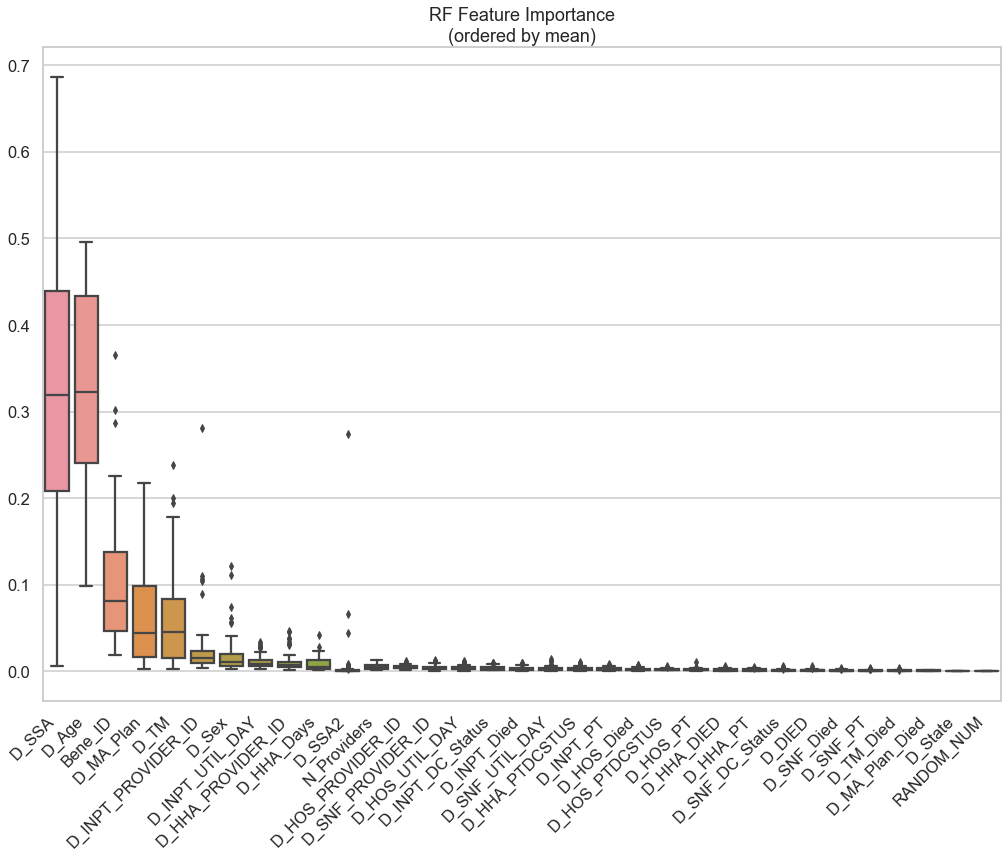

In [24]:
plt.figure(figsize=(15,10))
sns.set_context('talk')
sns.set_style("whitegrid")
sns.boxplot(data= FeatImport)
plt.tight_layout()
plt.title('RF Feature Importance\n(ordered by mean)')
plt.xticks(rotation = 45, ha='right')
plt.savefig(f'e:/PatrickBernard/figures/RF_Class/RF_FeatureImportanceBoxPlot.png',bbox_inches = 'tight')

**Build A mean-shift Classifier**  

this atempt was abandons because of computer resources. the classification did not complete.